## Sleep Quality Prediction - Supervised Machine Learning

---

by: Cody Hill

date: 1/18/2024

This project is intended for building machine learning predictive models on Oura Ring exported data. Since the data collection period is currently limited, this notebook is being built with the goal of continued data uploads (all data cleaning/analysis will be generalized for continuous new data).

### Data Source Information
All data has been exported from my personal Oura Ring on January 18, 2024 containing raw biometric data and Oura calculated data since I began wearing the device.
- Data collection starting 2/3/2023 to 1/18/2024 (last upload)
- [ Data explanations (URL to Oura?)]
### [ ADD LICENSE INFORMATION AND FAIR USE INFO ]

**TODO: oura_sleep_2024-01.csv**
- [X] Nap on day encoding
  - [X] `list(where ['type'] != long_sleep && between 10 AM - 7 PM)`
       Does the nap affect day of or next day? I chose day of
  - [X] sum(types of sleep duration)
- [ ] restless_periods vs sum(movement_30_sec) ??
- [X] Only one day per entry
  - [X] Sum each day sleep durations, restless_periods, awake_time, time_in_bed, total_sleep_duration
  - [X] `awake_time = time_in_bed - total_sleep_duration` ??
- [X] Save only the `['type'] == long_sleep, average_breath, average_heart_rate, average_hrv, latency, 
       lowest_heart_rate, betime_start_delta`
- [X] Remove: `efficiency, period, score, segment_state, sleep_midpoint, sleep_phase_5_min, movement_30_sec, timezone, 
       betime_end_delta, midpoint_at_delta, heart_rate_5_min, hrv_5_min`

**TODO: oura_daily-activity_2024-01.csv**
- [X] Remove: `average_met_minutes, equivalent_walking_distance, high_activity_met_minutes, inactivity_alerts, 
       low_activity_met_minutes, medium_activity_met_minutes, sedentary_met_minutes, target_calories, target_meters, score,
       class_5_min, met_1_min, ring_met_1_min`
- [ ] Workout today? daily boolean (Maybe unnecessary with other metrics compare models w/ and w/o)
- [X] Assign all activity to previous day???

**TODO: oura_daily-readiness_2024-01.csv**
- [X] Remove: `score, temperature_trend_deviation`

**TODO: oura_daily--spo2_2024-01.csv**
- [X] Deal with NaNs

**TODO: General**
- [X] Collinearity between features checks in model selection
- [X] Feature standardization/normalization
- [ ] Create Readme
- [ ] Create environment file for reproducibility
- [ ] Reroute filepath to align with github cloning.
- [ ] Deal with NaNs using a generalized method
- [X] Bin the Ys!
  - [X] Even-width bins
  - [X] Quantile bin method
- [X] Balance train and test split classes? Note: Only works with more data, currently remove outliers (when class n < 2)
- [X] Implement regression friendly dataframe.
- [ ] ROC Curve or F1
- [ ] Previous Day's Sleep Score feature (assuming previous day sleep affects current day)
- [ ] oversampling/SMOTE 
- [X] Different models
- [X] Reduce Features
  - [X] Correlation matrix
  - [ ] Recursive solution: forward, backward, best subset
  - [ ] sklearn.feature_selection >> RFE
- [ ] Define the problem.
  - [ ] Choose logistic regression or regression and make a case for why.
- [ ] Ensemble solution?

In [314]:
import os
import numpy as np
import pandas as pd
import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeClassifier
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

### Setup and Data Cleaning

In [315]:
# Import data
# TODO: Switch this to the github urls for the data so others can use.
data_folder = '/Users/chill/GitHub/Supervised-Sleep/Data'
sleep_data_folder = '/Users/chill/GitHub/Supervised-Sleep/Data/Sleep_Data'

# Iterate through each file in .Data/ and add it to a dataframe.
file_path = [f'{data_folder}/{file}' for file in os.listdir(data_folder) if '.csv' in file]
# Using a list to concat the dfs with index_col allows to easily merge based on 'day'. More memory usage but fine for this project.
biometric_df = pd.concat([pd.read_csv(file, index_col = 'day') for file in file_path], join = 'outer', ignore_index = False, axis = 1).reset_index()

# Iterate through each file in .Data/Sleep_Data and add it to a dataframe.
# Separated sleep data as it potentially has multiple entries per day. Will merge them later.
file_path_sleep = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' not in file]
sleep_df = pd.concat(map(pd.read_csv, file_path_sleep), join = 'outer', ignore_index = False, axis = 1)

# Import ground truth label sleep score.
file_path_daily_sleep_score = [f'{sleep_data_folder}/{file}' for file in os.listdir(sleep_data_folder) if '.csv' in file and 'daily' in file]
daily_sleep_score_df = pd.read_csv(file_path_daily_sleep_score[0])
daily_sleep_score_df = daily_sleep_score_df[['score', 'day']]

In [316]:
# First looks
print('biometric_df info:\n------------------\n', biometric_df.shape)
display(biometric_df.head(2))
print(biometric_df.columns)
print('\n\nsleep_df info:\n------------------\n', sleep_df.shape)
display(sleep_df.head(4))
print(sleep_df.columns)

biometric_df info:
------------------
 (350, 42)


,day,spo2_percentage,active_calories,average_met_minutes,equivalent_walking_distance,high_activity_met_minutes,high_activity_time,inactivity_alerts,low_activity_met_minutes,low_activity_time,...,temperature_deviation,temperature_trend_deviation,contributors_activity_balance,contributors_hrv_balance,contributors_previous_day_activity,contributors_previous_night,contributors_recovery_index,contributors_resting_heart_rate,contributors_sleep_balance,contributors_body_temperature
0,2023-02-04,98.523,650,1.59375,10728,16,120,0,277,23220,...,-0.38,NaN,NaN,NaN,96.0,74.0,97.0,94.0,NaN,90.0
1,2023-02-05,97.181,498,1.43750,8458,8,60,0,204,15000,...,-0.04,0.15,NaN,NaN,82.0,79.0,100.0,59.0,NaN,100.0


Index(['day', 'spo2_percentage', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'score',
       'class_5_min', 'contributors_meet_daily_targets',
       'contributors_move_every_hour', 'contributors_recovery_time',
       'contributors_stay_active', 'contributors_training_frequency',
       'contributors_training_volume', 'met_1_min', 'ring_met_1_min', 'score',
       'temperature_deviation', 'temperature_trend_deviation',
       'contributors_activity_balance', 'contributors_hrv_balance',
       'contributors_previous_day_activity', 'contributors_previous_night',
       'contributors_recov

,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,efficiency,latency,...,readiness_contributors_body_temperature,readiness_contributors_hrv_balance,readiness_contributors_previous_day_activity,readiness_contributors_previous_night,readiness_contributors_recovery_index,readiness_contributors_resting_heart_rate,readiness_contributors_sleep_balance,readiness_score,readiness_temperature_deviation,readiness_temperature_trend_deviation
0,13.625,63.25,77.0,4440.0,2023-02-04T07:08:22.000-06:00,2023-02-03T22:40:22.000-06:00,2023-02-04,4650.0,85.0,990.0,...,90.0,NaN,96.0,74.0,97.0,94.0,NaN,89.0,-0.38,NaN
1,15.125,92.49,19.0,6210.0,2023-02-05T09:37:28.000-06:00,2023-02-04T23:54:28.000-06:00,2023-02-05,4590.0,82.0,180.0,...,100.0,NaN,82.0,79.0,100.0,59.0,NaN,78.0,-0.04,0.15
2,15.125,87.67,NaN,1920.0,2023-02-05T20:10:57.000-06:00,2023-02-05T19:36:57.000-06:00,2023-02-06,30.0,6.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,15.125,82.50,37.0,720.0,2023-02-05T20:36:02.000-06:00,2023-02-05T20:20:02.000-06:00,2023-02-06,0.0,25.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'latency', 'light_sleep_duration', 'lowest_heart_rate',
       'movement_30_sec', 'period', 'rem_sleep_duration', 'restless_periods',
       'score', 'segment_state', 'sleep_midpoint', 'time_in_bed',
       'total_sleep_duration', 'type', 'sleep_phase_5_min', 'timezone',
       'bedtime_start_delta', 'bedtime_end_delta', 'midpoint_at_delta',
       'heart_rate_5_min', 'hrv_5_min', 'contributors_total_sleep',
       'contributors_deep_sleep', 'contributors_rem_sleep',
       'contributors_efficiency', 'contributors_latency',
       'contributors_restfulness', 'contributors_timing',
       'readiness_contributors_activity_balance',
       'readiness_contributors_body_temperature',
       'readiness_contributors_hrv_balance',
       'readiness_contributors_previous_day_activity',
       'readiness_contributors_previous_night'

As we can see, the Oura Ring tracks and records quite a few biometrics, and with that raw biometric data they also are feature engineering and calculating new metrics to assign a daily score to categories such as sleep, recovery, readiness, activity, etc. totalling 89 features.

Since the purpose of this is to create our own sleep score predictive model, we can use Oura's sleep score as our ground truth label (y_train) in training and validation. Furthermore, we must remove the features with labels that include "contributors" as these columns contain standardized scores which Oura's models have output that are then used to average out into the final score.

*Note:* Two dataframes have been intialized here because some of the data has one entry per day (`biometric_df`), but the sleep data potentially has multiple entries per day (`sleep_df`). This was done for ease of transforming the data later.

In [317]:
print('\n\ndaily_sleep_score_df info:\n--------------------------\n',daily_sleep_score_df.shape)
display(daily_sleep_score_df.head(4))



daily_sleep_score_df info:
--------------------------
 (336, 2)


,score,day
0,81,2023-02-04
1,81,2023-02-05
2,89,2023-02-06
3,78,2023-02-07


In [318]:
# Remove contributor and score columns (multiple scores involved, will add truth label later).
biometric_df = biometric_df.loc[:, ~biometric_df.columns.str.contains('contributors|score')]
sleep_df = sleep_df.loc[:, ~sleep_df.columns.str.contains('contributors|score')]

print(biometric_df.shape)
print(sleep_df.shape)

(350, 26)
(685, 30)


We've removed 33 feature columns containing the word 'contributors' (or 'score' since we'll be using the score in `daily_sleep_score_df`).

Let's take a closer look at the remaining features and continue further data preparations.

In [319]:
print(biometric_df.columns, sleep_df.columns)

Index(['day', 'spo2_percentage', 'active_calories', 'average_met_minutes',
       'equivalent_walking_distance', 'high_activity_met_minutes',
       'high_activity_time', 'inactivity_alerts', 'low_activity_met_minutes',
       'low_activity_time', 'medium_activity_met_minutes',
       'medium_activity_time', 'meters_to_target', 'non_wear_time',
       'resting_time', 'sedentary_met_minutes', 'sedentary_time', 'steps',
       'target_calories', 'target_meters', 'total_calories', 'class_5_min',
       'met_1_min', 'ring_met_1_min', 'temperature_deviation',
       'temperature_trend_deviation'],
      dtype='object') Index(['average_breath', 'average_heart_rate', 'average_hrv', 'awake_time',
       'bedtime_end', 'bedtime_start', 'day', 'deep_sleep_duration',
       'efficiency', 'latency', 'light_sleep_duration', 'lowest_heart_rate',
       'movement_30_sec', 'period', 'rem_sleep_duration', 'restless_periods',
       'segment_state', 'sleep_midpoint', 'time_in_bed',
       'total_sleep_d

In [320]:
# Confirm there are no duplicates of days in the biometric data.
biometric_df['day'].duplicated().sum()

0

We'll be removing any features that don't seem relevant to our sleep score prediction models. For now we will not touch any potentially "overlapping" features that might introduce predictor collinearity issues, but will address them later.

We'll also take a look at the remaining features' data types and see if any data munging is necessary (formatting all the features (float, int, dates, dummy/indicator encoding)).

In [321]:
# Columns to drop
# sleep_df
drop_col_sleep = ['efficiency', 'period', 'segment_state',
            'sleep_midpoint', 'sleep_phase_5_min', 'movement_30_sec',
            'timezone', 'bedtime_end_delta', 'midpoint_at_delta',
            'heart_rate_5_min', 'hrv_5_min'] # timezone? -- might need during EDA
sleep_df.drop(drop_col_sleep, axis = 1, inplace = True)

# biometric_df
drop_col_bio = ['average_met_minutes', 'equivalent_walking_distance', 
                'high_activity_met_minutes', 'inactivity_alerts', 
                'low_activity_met_minutes', 'medium_activity_met_minutes', 
                'sedentary_met_minutes', 'target_calories', 
                'target_meters', 'class_5_min', 
                'met_1_min', 'ring_met_1_min', 
                'temperature_trend_deviation']
biometric_df.drop(drop_col_bio, axis = 1, inplace = True)

# Reformat date columns
date_col_sleep = ['bedtime_end', 'bedtime_start', 'day']
# All times reformatted to UTC
sleep_df[date_col_sleep] = sleep_df[date_col_sleep].apply(pd.to_datetime, utc = True, errors = 'coerce')
biometric_df['day'] = biometric_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')
daily_sleep_score_df['day'] = daily_sleep_score_df['day'].apply(pd.to_datetime, utc = True, errors = 'coerce')

In [322]:
# Placeholder: testing for EDA using dropped timezone column
tzone = -240
f"{int(tzone / 10 / 6)}:00"

'-4:00'

In [323]:
print(biometric_df.dtypes)
print(sleep_df.dtypes)

day                      datetime64[ns, UTC]
spo2_percentage                      float64
active_calories                        int64
high_activity_time                     int64
low_activity_time                      int64
medium_activity_time                   int64
meters_to_target                       int64
non_wear_time                          int64
resting_time                           int64
sedentary_time                         int64
steps                                  int64
total_calories                         int64
temperature_deviation                float64
dtype: object
average_breath                                       float64
average_heart_rate                                   float64
average_hrv                                          float64
awake_time                                           float64
bedtime_end                              datetime64[ns, UTC]
bedtime_start                            datetime64[ns, UTC]
day                                

Everything above looks good, we can see that `['type']` is an object which likely means it's a string. Let's see what values it can take.

In [324]:
sleep_df['type'].unique()

array(['long_sleep', nan, 'late_nap', 'rest', 'sleep'], dtype=object)

We can use this information along with the time data in the next section to identify different periods of sleep.

Like was mentioned before, the `sleep_df` contains multiple entries per day which either is interrupted sleep during the night or afternoon naps. Eventually we need all the data in one dataframe but first we can engineer some features with this information. 

A reasonable solution seems to be to total all the sleep categories that occurred per day, accounting for sleep interruptions at night, and any naps counting towards that total as well. However, we will lose that nap information when we total the sleep times and it might also be beneficial to identify days in which naps occur using a binary boolean (0 = No Nap, 1 = Yes Nap), potentially increasing the sleep score. We will make a new feature with the sleep information before consolidation.

In [325]:
# Initialize a time frame we can consider a nap/rest period (UTC format).
nap_upper = pd.to_datetime('23:59:00').time()
nap_lower = pd.to_datetime('14:00:00').time()
# Condition on the start, end time, and total sleep duration to filter out false-positives, remove any long_sleep types.
nap_bool = ((sleep_df['bedtime_start'].dt.time >= nap_lower) & 
            (sleep_df['bedtime_end'].dt.time <= nap_upper) & 
            (sleep_df['total_sleep_duration'] > 600) &
            (sleep_df['type'] != 'long_sleep'))
print('Naps identified:\n')
display(sleep_df[nap_bool])
# Insert a nap_today column and binary yes/no for each day.
# Initialize column with zeroes.
sleep_df['nap_today'] = np.zeros_like(sleep_df.shape[0])
# Use boolean array to identify nap days and iterate through to change nap_today to 1.
# TODO: This is not the pandas way but is fine with this amount of data. Use a better method later.
# Something like, sleep_df['nap_today'].where(~nap_bool, 1, inplace = True) does not work in this situation..
# Need each entry for that day to = 1 not just the nap itself.
nap_days = sleep_df[nap_bool]['day']
for day in nap_days:
    sleep_df.loc[sleep_df['day'] == day, 'nap_today'] = 1

Naps identified:



,average_breath,average_heart_rate,average_hrv,awake_time,bedtime_end,bedtime_start,day,deep_sleep_duration,latency,light_sleep_duration,lowest_heart_rate,rem_sleep_duration,restless_periods,time_in_bed,total_sleep_duration,type,bedtime_start_delta,readiness_temperature_deviation,readiness_temperature_trend_deviation
31,13.500,74.47,34.0,6270.0,2023-02-20 21:16:13+00:00,2023-02-20 19:05:13+00:00,2023-02-20 00:00:00+00:00,420.0,570.0,840.0,67.0,330.0,25.0,7860,1590.0,NaN,47113,NaN,NaN
34,13.875,70.14,58.0,3540.0,2023-02-21 23:27:03+00:00,2023-02-21 21:59:03+00:00,2023-02-21 00:00:00+00:00,120.0,3600.0,1140.0,60.0,480.0,23.0,5280,1740.0,NaN,57543,NaN,NaN
44,14.750,90.50,25.0,3690.0,2023-02-27 01:11:23+00:00,2023-02-26 23:54:23+00:00,2023-02-27 00:00:00+00:00,300.0,2760.0,540.0,90.0,90.0,24.0,4620,930.0,NaN,60863,NaN,NaN
53,14.750,NaN,NaN,1140.0,2023-03-01 23:27:00+00:00,2023-03-01 22:51:00+00:00,2023-03-01 00:00:00+00:00,570.0,750.0,420.0,NaN,30.0,11.0,2160,1020.0,NaN,60660,NaN,NaN
63,14.625,71.67,NaN,930.0,2023-03-06 22:03:32+00:00,2023-03-06 21:30:32+00:00,2023-03-06 00:00:00+00:00,630.0,390.0,420.0,70.0,0.0,31.0,1980,1050.0,NaN,55832,NaN,NaN
88,13.750,65.15,75.0,1530.0,2023-03-17 21:33:33+00:00,2023-03-17 20:17:33+00:00,2023-03-17 00:00:00+00:00,90.0,450.0,2940.0,62.0,0.0,88.0,4560,3030.0,NaN,55053,NaN,NaN
89,13.750,68.33,63.0,2070.0,2023-03-17 23:52:33+00:00,2023-03-17 22:48:33+00:00,2023-03-18 00:00:00+00:00,540.0,1410.0,780.0,63.0,450.0,12.0,3840,1770.0,late_nap,64113,NaN,NaN
116,13.625,70.40,70.0,3030.0,2023-03-30 20:27:01+00:00,2023-03-30 19:26:01+00:00,2023-03-30 00:00:00+00:00,180.0,690.0,450.0,68.0,0.0,10.0,3660,630.0,NaN,51961,NaN,NaN
152,14.125,61.20,107.0,750.0,2023-04-23 21:10:49+00:00,2023-04-23 20:29:49+00:00,2023-04-23 00:00:00+00:00,1260.0,330.0,450.0,56.0,0.0,15.0,2460,1710.0,sleep,55789,NaN,NaN
180,14.875,71.20,80.0,1080.0,2023-05-10 18:45:42+00:00,2023-05-10 17:44:42+00:00,2023-05-10 00:00:00+00:00,810.0,570.0,1770.0,67.0,0.0,29.0,3660,2580.0,sleep,45882,NaN,NaN


Continuing to setup our feature dataframe, the day in which the biometric data is being collected will affect the next day. Currently, and maybe obviously, the sleep score is recorded on the day you wake on, meaning each date is referencing the previous night's sleep. This is important to note because the features we're left with (e.g., calories burned, steps, heart rate, etc) in the `biometric_df` is being collected on the day in which a sleep score has already been recorded . Logically this data is more relevant to the upcoming night's sleep, therefore, since we're organizing metrics per day, we need to shift this date 1 day to align with our model's target/response variable (sleep score).

*Example:*

**Original**
| Score | Day (sleep_df) | Bedtime Start | Bedtime End | / | / | Day (biometric_df) | Steps | Active Calories |
|-------|-----|---------------|-------------|---|---|-----|-------|-----------------|
|...|...|...|...|/|/|...|...|...|
| 81 | 01/20/2024 | 1/19/2024 22:30 | 1/20/2024 07:00 |/|/| 01/20/2024 | 13000 | 800 |
| 65 | 01/21/2024 | 1/20/2024 23:45 | 1/21/2024 05:20 |/|/| 01/21/2024 | 21000 | 1900 |
|...|...|...|...|/|/|...|...|...|

**New DF** - Shifted biometric data to next day, aligning with relevant sleep score.
| Score | Day (sleep_df) | Bedtime Start | Bedtime End | / | / | ~~Day (biometric_df)~~ | Steps | Active Calories |
|-------|-----|---------------|-------------|---|---|-----|-------|-----------------|
| 81 | 01/20/2024 | 1/19/2024 22:30 | 1/20/2024 07:00 |/|/|$\Downarrow$ ~~01/19/2024~~ |$\Downarrow$ 14000 |$\Downarrow$ 600 |
| 65 | 01/21/2024 | 1/20/2024 23:45 | 1/21/2024 05:20 |/|/|$\Downarrow$ ~~01/20/2024~~ |$\Downarrow$ 13000 |$\Downarrow$ 800 |
| 73 | 01/22/2024 | 1/21/2024 23:00 | 1/22/2024 07:20 |/|/|$\Downarrow$ ~~01/21/2024~~ |$\Downarrow$ 21000 |$\Downarrow$ 1900 |

In [326]:
# Shift day one day into the future to align with relevant sleep score day.
biometric_df['day'] = biometric_df['day'] + pd.DateOffset(days = 1)
# Remove last day in biometric dataset since it won't have a sleep score with day shifting.
bio_max_idx = biometric_df.loc[biometric_df['day'] == biometric_df['day'].max()].index
biometric_df.drop(index = bio_max_idx, axis = 0, inplace = True)

# Verify each dataframe starts and ends on the same day.
print('Earliest Dates in each DF:')
print(biometric_df['day'].min(), '<-- biometric_df')
print(sleep_df['day'].min(), '<-- sleep_df')
print(daily_sleep_score_df['day'].min(), '<-- daily_sleep_score_df')
print('\nLatest Dates in each DF:')
print(biometric_df['day'].max(), '<-- biometric_df')
print(sleep_df['day'].max(), '<-- sleep_df')
print(daily_sleep_score_df['day'].max(), '<-- daily_sleep_score_df')

Earliest Dates in each DF:
2023-02-04 00:00:00+00:00 <-- biometric_df
2023-02-04 00:00:00+00:00 <-- sleep_df
2023-02-04 00:00:00+00:00 <-- daily_sleep_score_df

Latest Dates in each DF:
2024-01-18 00:00:00+00:00 <-- biometric_df
2024-01-18 00:00:00+00:00 <-- sleep_df
2024-01-18 00:00:00+00:00 <-- daily_sleep_score_df


In [327]:
# Identify days where there wasn't a long period of sleep
sleep_df_long = sleep_df.loc[sleep_df['type'] == 'long_sleep']

# Use merge() to find the differences in dataframes indicating days that didn't record a long sleep.
# Requires a method where the two df indexes don't match.
# Credit to: https://stackoverflow.com/questions/48647534/find-difference-between-two-data-frames
no_sleep = pd.DataFrame(sleep_df['day']).merge(sleep_df_long['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']
print('Entries in which no long periods of sleep were recorded that day:')
display(no_sleep)

# We can remove these days with no long_sleep from the main dataframes as they won't have sleep scores anyways.
    # Sleep DF
sleep_df.drop(no_sleep.index, axis = 0, inplace = True)

    # Biometric DF
    # We can use our previous work and just remove the days that the two DFs don't share.
no_sleep_bio_days =  pd.DataFrame(biometric_df['day']).merge(sleep_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day']
no_sleep_bio_index = biometric_df[biometric_df['day'].isin(no_sleep_bio_days)].index
biometric_df.drop(no_sleep_bio_index, axis = 0, inplace = True)

    # Daily Sleep Score DF
no_sleep_score_index = pd.DataFrame(daily_sleep_score_df['day']).merge(biometric_df['day'], indicator = True, how='left').loc[lambda x : x['_merge']!='both']['day'].index
daily_sleep_score_df.drop(index = no_sleep_score_index, axis = 0, inplace = True)
    # We can now remove the day column from the daily_sleep_score_df
daily_sleep_score_df.drop(['day'], axis = 1, inplace = True)

Entries in which no long periods of sleep were recorded that day:


,day,_merge
103,2023-03-24 00:00:00+00:00,left_only
140,2023-04-15 00:00:00+00:00,left_only
161,2023-05-01 00:00:00+00:00,left_only
162,2023-05-01 00:00:00+00:00,left_only
163,2023-05-02 00:00:00+00:00,left_only
173,2023-05-08 00:00:00+00:00,left_only
223,2023-05-28 00:00:00+00:00,left_only
224,2023-05-28 00:00:00+00:00,left_only
326,2023-07-24 00:00:00+00:00,left_only
402,2023-08-31 00:00:00+00:00,left_only


As we've seen, our target variable sleep score is in the form of discrete integers. This data comes to us from Oura's own models in which the exact process of how it was obtained has been obfuscated from us. There's an argument to be made whether or not we should treat this as a regression task or classification task, or whether there's ever merit in casting a regression task into the classification space, as it almost certainly introduces bias and loses information, but we will discuss that further later. 

For now, since this is just an exercise and since our dataset has relatively few samples, it might be beneficial to explore transforming the sleep score into categorical variable bins. We will keep the discrete sleep score column for use in our models, but create another column which indicates which bin that score falls into for use in logistic regression.

We have a few different methods we can use to approach how to categorize sleep scores:
- The simplest would be to create (n) bins and evenly space them.
  - Pros: 
    - Easy to implement.
    - Handles data drift in the case of the addition of new data.
  - Cons: 
    - Creates rather arbitrary boundaries and thus arbitrary class interpretation.
    - Likely to create heavily imbalanced classes.
    - Outliers are not addressed with this method.
    - Potentially creates empty classes.
- Look at the distribution of the scores and use the standard deviation to help find the bin intervals. (Sometimes called median-centered/quantile binning.)
  - Pros: 
    - Distributes classes along the data distribution.
    - Limits the affect of outliers since bins will widen as they get further away from the median.
    - Increased edge and class interpretation.
    - Pandas has qcut() and cut() to help with implementation.
  - Cons: 
    - Still need to decide how many bins to create.

Here we will implement a few versions of these binning techniques and analyze which makes the most sense for our sleep score data.

Even-Width Bins

---

Below, the even-width binning method has been implemented with 10 bins with a width of 10. An offset of 0.5 was used so the edges would automatically decide which bin to take since our sleep score data all hold discrete values. Justifications for these parameters were fairly arbitrary, but seemed justifiable that there is a difference between a sleep score of 79 than, say, 88.

You'll notice that once overlaid the distribution of the sleep score data, there appears to be a lot of wasted bins that don't capture any data. Logically you would think to increase the bin size, reducing the total number, but you quickly run into a different problem. If you increase the bin size you risk having the majority of the data land in only a few classes, and arguably that's a problem we have here too using 10 bins. Decreasing the bin size will arguably make the interpretability of the class boundaries worse and increase the outlier effects.

['0.5 to 10.5', '10.5 to 20.5', '20.5 to 30.5', '30.5 to 40.5', '40.5 to 50.5', '50.5 to 60.5', '60.5 to 70.5', '70.5 to 80.5', '80.5 to 90.5', '90.5 to 100.5']


score_bin_even
70.5 to 80.5     155
80.5 to 90.5      98
60.5 to 70.5      65
50.5 to 60.5       7
40.5 to 50.5       5
90.5 to 100.5      3
30.5 to 40.5       1
Name: count, dtype: int64

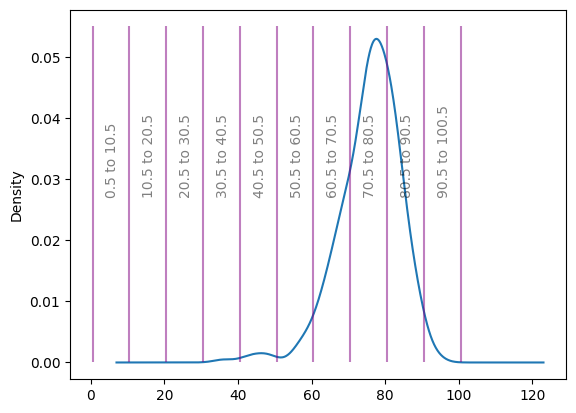

In [328]:
# Instead of having 0-100 potential label predictions when using a classification model,
# we should create a categorical 'binned' label column.
# Create bins. We can use .5 to easily decide left edge or right edge issues.
bin_number = 10
bin_interval_even = np.linspace(0.5, 100.5, bin_number + 1, dtype = float)
bin_labels = [f"{i} to {i + bin_number}" for i in bin_interval_even if i != bin_interval_even[-1]]
# np.digitize() can map the sleep scores to the correct bins
bin_idx = np.digitize(daily_sleep_score_df['score'], bin_interval_even, right = False)
# Create new column with the new bin labels
bin_map_even = [bin_labels[value - 1] for value in bin_idx]
daily_sleep_score_df['score_bin_even'] = bin_map_even
print(bin_labels)
display(daily_sleep_score_df['score_bin_even'].value_counts())

daily_sleep_score_df['score'].plot(kind='kde')
plt.vlines(bin_interval_even, ymin = 0, ymax = 0.055, color = 'purple', alpha = 0.5)
for idx, label in enumerate(bin_labels):
    plt.text(x = ((bin_interval_even[idx] + bin_interval_even[idx + 1]) / 2) - 1.5,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = label,
             rotation = 'vertical',
             alpha = 0.5)

Quantile/Median-Centered Bins

---

Here is the implementation of the quantile binning method. With very little parameter tweaking you can see the bin intervals overlaid on the distribution fits the data much better. Producing bins with reasonable balance that matches the data distribution. Another positive attribute of this method is the min and max interval starts at the min and max values of the data. You can see how this method will limit how outliers affect our classifications by way of naturally widening bins by a scalar of the standard deviation as they get further from the median value.

Quantile Bins: [36. 68. 74. 77. 80. 83. 94.]

Distribution of Bins: score
Bad          64
Below Avg    61
Worst        57
Best         52
Above Avg    51
Good         49
Name: count, dtype: int64


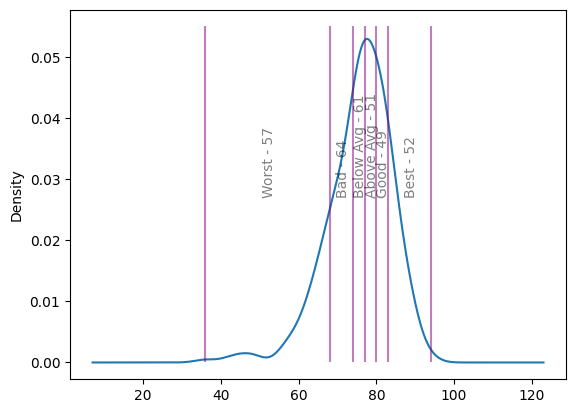

In [329]:
labels_quantile = ['Worst', 'Bad', 'Below Avg','Above Avg', 'Good', 'Best']
bin_map_quantile, bin_interval_quantile = pd.qcut(daily_sleep_score_df['score'], 6, labels = labels_quantile, retbins = True)
daily_sleep_score_df['score_bin_quantile'] = bin_map_quantile

print('Quantile Bins:', bin_interval_quantile)
print('\nDistribution of Bins:', bin_map_quantile.value_counts())
daily_sleep_score_df['score'].plot(kind='kde')
plt.vlines(bin_interval_quantile, ymin = 0, ymax = 0.055, color = 'purple', alpha = 0.5)
for idx, label in enumerate(labels_quantile):
    plt.text(x = ((bin_interval_quantile[idx] + bin_interval_quantile[idx + 1]) / 2) - 1.5,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = f'{label} - {bin_map_quantile.value_counts()[label]}',
             rotation = 'vertical',
             alpha = 0.5)

Custom Quantile Bins

---

The creation of this method isn't too dissimilar to the previous quantile bin implementation, but uses only the median and standard deviation to create each interval. Since this data is my own, the justifications were based on insights of my own perception of sleep quality (i.e., I believe my sleep generally skews towards poor sleep, therefore the bins and total number of classes in each should reflect that perception which is backed up here by the distribution's left tailedness.). *Note: I did not use any hard-coding to get these intervals, only the median and standard deviations so it will adjust when the data is updated, potentially shifting if my sleep consistently gets better.*

Custom Quantile Bins: [0, 64.42331179284814, 72.80777059761604, 77.0, 81.19222940238396, 89.57668820715186, 100]

Distribution of Bins: score
Below Avg    83
Good         75
Above Avg    73
Bad          71
Worst        28
Best          4
Name: count, dtype: int64


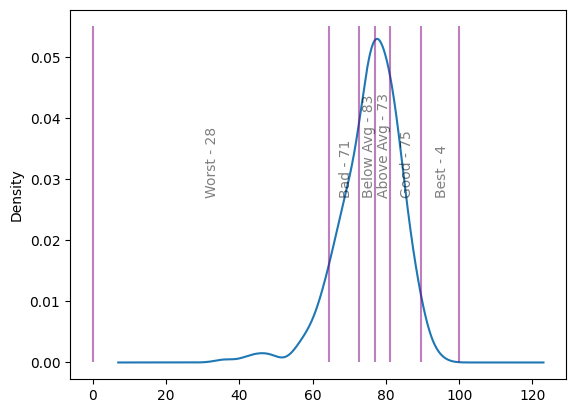

In [330]:
labels_custom = ['Worst', 'Bad', 'Below Avg', 'Above Avg', 'Good', 'Best']
median_score = daily_sleep_score_df['score'].median()
std_score = daily_sleep_score_df['score'].std()
bin_interval_custom = [0,
            median_score - (1.5 * std_score),
            median_score - (0.5 * std_score),
            median_score,
            median_score + (0.5 * std_score),
            median_score + (1.5 * std_score),
            100]
bin_map_custom = pd.cut(daily_sleep_score_df['score'], bins = bin_interval_custom, labels = labels_custom)
daily_sleep_score_df['score_bin_custom'] = bin_map_custom

print('Custom Quantile Bins:', bin_interval_custom)
print('\nDistribution of Bins:', bin_map_custom.value_counts())
daily_sleep_score_df['score'].plot(kind='kde')
plt.vlines(bin_interval_custom, ymin = 0, ymax = 0.055, color = 'purple', alpha = 0.5)
for idx, label in enumerate(labels_custom):
    plt.text(x = ((bin_interval_custom[idx] + bin_interval_custom[idx + 1]) / 2) - 1.5,
             y = (plt.ylim()[0] + plt.ylim()[1]) / 2,
             s = f'{label} - {bin_map_custom.value_counts()[label]}',
             rotation = 'vertical',
             alpha = 0.5)

In [331]:
display(daily_sleep_score_df.tail(5))

,score,score_bin_even,score_bin_quantile,score_bin_custom
331,77,70.5 to 80.5,Below Avg,Below Avg
332,85,80.5 to 90.5,Best,Good
333,64,60.5 to 70.5,Worst,Worst
334,77,70.5 to 80.5,Below Avg,Below Avg
335,71,70.5 to 80.5,Bad,Bad


Finally, now that we've extracted the features we wanted from `sleep_df`, we can total the multiple sleep entries per day and then combine the sleep metrics with the biometric data. 

*Note: some metrics are not summed in this process, and of those, only the metrics tied to the `'long_sleep'` entry will be used in the final dataset. (e.g., we don't really care what the average heart rate variability (`['average_hrv']`) or (`['latency']`) is for an interrupted sleep section during the night that only lasted 30 minutes.)*

In [332]:
# Sum each day's sleep metrics (important for days with interrupted sleep or naps).
# Overwrites each day's entry.
sleep_df = sleep_df[['day', 
         'deep_sleep_duration', 
         'light_sleep_duration', 
         'rem_sleep_duration', 
         'restless_periods', 
         'awake_time', 
         'time_in_bed', 
         'total_sleep_duration']].groupby(['day']).sum().reset_index()

# Features extracted only from the long sleep to include in the final dateframe.
sleep_df_long = sleep_df_long[['day', 
                               'average_breath', 
                               'average_heart_rate', 
                               'average_hrv', 
                               'latency', 
                               'lowest_heart_rate', 
                               'bedtime_start_delta',
                               'nap_today']]
# Merge the summed features with the long_sleep-only features.
sleep_df = sleep_df.merge(sleep_df_long, on = 'day', how = 'outer')
sleep_df.head(2)

,day,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,latency,lowest_heart_rate,bedtime_start_delta,nap_today
0,2023-02-04 00:00:00+00:00,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,77.0,990.0,56.0,-4778,0
1,2023-02-05 00:00:00+00:00,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,19.0,180.0,75.0,-332,0


Now that all feature cleaning, creation, and transformations are complete we should verify each dataframe matches shape for the upcoming merge.

In [333]:
print('Verify all DF.shape matches:', sleep_df.shape[0] == biometric_df.shape[0] == daily_sleep_score_df.shape[0])
print(sleep_df.shape, '<-- sleep_df')
print(biometric_df.shape, '<-- biometric_df')
print(daily_sleep_score_df.shape, '<-- daily_sleep_score_df')

Verify all DF.shape matches: True
(334, 15) <-- sleep_df
(334, 13) <-- biometric_df
(334, 4) <-- daily_sleep_score_df


Now, let's create one dataframe for the features and display them.

In [334]:
# Merge sleep and biometric DFs.
bio_sleep_df = sleep_df.merge(biometric_df, on = 'day', how = 'outer')
display(bio_sleep_df)
print(bio_sleep_df.columns)

,day,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,...,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
0,2023-02-04 00:00:00+00:00,4650.0,15570.0,5820.0,282.0,4440.0,30480,26040.0,13.625,63.25,...,0,8460,120,6300,36000,19680,22140,2718,2429,NaN
1,2023-02-05 00:00:00+00:00,4590.0,14970.0,9210.0,240.0,6210.0,34980,28770.0,15.125,92.49,...,120,23220,2940,0,0,25740,34380,11638,3075,-0.38
2,2023-02-06 00:00:00+00:00,8580.0,15210.0,7350.0,302.0,6240.0,37380,31140.0,13.625,68.76,...,60,15000,2580,2700,0,35280,33480,9001,2814,-0.04
3,2023-02-07 00:00:00+00:00,4500.0,17700.0,6030.0,284.0,5010.0,33240,28230.0,13.500,67.25,...,120,13440,2160,5300,0,31080,39600,7544,2748,-0.22
4,2023-02-08 00:00:00+00:00,4920.0,15630.0,6420.0,245.0,6210.0,33180,26970.0,13.875,69.50,...,0,16560,3180,2300,4800,31020,30840,8668,2852,-0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329,2024-01-14 00:00:00+00:00,3090.0,19680.0,5760.0,253.0,9469.0,37999,28530.0,13.625,66.03,...,300,18900,5580,-6500,180,35760,25680,14452,3212,0.15
330,2024-01-15 00:00:00+00:00,5610.0,17970.0,5340.0,288.0,6456.0,35376,28920.0,13.875,69.69,...,0,15000,1860,1100,14580,34860,20100,7651,2713,-0.12
331,2024-01-16 00:00:00+00:00,5910.0,11310.0,4230.0,240.0,4734.0,26184,21450.0,13.500,57.40,...,240,18840,3300,-300,540,27960,35520,11561,3064,0.05
332,2024-01-17 00:00:00+00:00,5640.0,10230.0,7020.0,221.0,3768.0,26658,22890.0,13.875,57.75,...,0,19920,1740,900,300,26880,37560,8525,2879,-0.33


Index(['day', 'deep_sleep_duration', 'light_sleep_duration',
       'rem_sleep_duration', 'restless_periods', 'awake_time', 'time_in_bed',
       'total_sleep_duration', 'average_breath', 'average_heart_rate',
       'average_hrv', 'latency', 'lowest_heart_rate', 'bedtime_start_delta',
       'nap_today', 'spo2_percentage', 'active_calories', 'high_activity_time',
       'low_activity_time', 'medium_activity_time', 'meters_to_target',
       'non_wear_time', 'resting_time', 'sedentary_time', 'steps',
       'total_calories', 'temperature_deviation'],
      dtype='object')


In [335]:
bio_sleep_df.reset_index(drop = True, inplace = True)
daily_sleep_score_df.reset_index(drop = True, inplace = True)

Lastly, we need to see what data is missing from our final dataframe and rectify any issues found.

In [336]:
# Explore and deal with NaN values.
# A good option to deal with each feature individually.
# >>> values = {{"Feature 1": .median(), "Feature 2": 0, "Feature 3: .mean()}}
# >>> df.fillna(value=values)
# Only feature with NaN currently is SPO2, median for now.
# TODO: Come back and tune each feature.
display(bio_sleep_df.isna().any())
bio_sleep_df.fillna(bio_sleep_df.median(), inplace = True)
display(f'Number of NaN values remaining after adjustments: {bio_sleep_df.isna().any().sum()}')

day                      False
deep_sleep_duration      False
light_sleep_duration     False
rem_sleep_duration       False
restless_periods         False
awake_time               False
time_in_bed              False
total_sleep_duration     False
average_breath           False
average_heart_rate       False
average_hrv              False
latency                  False
lowest_heart_rate        False
bedtime_start_delta      False
nap_today                False
spo2_percentage           True
active_calories          False
high_activity_time       False
low_activity_time        False
medium_activity_time     False
meters_to_target         False
non_wear_time            False
resting_time             False
sedentary_time           False
steps                    False
total_calories           False
temperature_deviation     True
dtype: bool

'Number of NaN values remaining after adjustments: 0'

### Exploratory Data Analysis (EDA)

In [337]:
bio_sleep_df.describe()

,deep_sleep_duration,light_sleep_duration,rem_sleep_duration,restless_periods,awake_time,time_in_bed,total_sleep_duration,average_breath,average_heart_rate,average_hrv,...,high_activity_time,low_activity_time,medium_activity_time,meters_to_target,non_wear_time,resting_time,sedentary_time,steps,total_calories,temperature_deviation
count,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,...,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.000000,334.00000,334.000000,334.000000
mean,5308.203593,15327.485030,5499.520958,245.068862,6400.500000,32539.122754,26135.209581,13.898952,65.677365,76.511976,...,110.479042,17283.413174,3105.808383,-1476.946108,3044.550898,30954.610778,31815.628743,10810.94012,2940.802395,0.012904
std,1673.540350,2473.891591,1469.245402,54.854200,2934.550056,4166.980359,3223.310338,0.462042,7.631848,25.629694,...,149.687596,4853.044649,1868.933254,4546.322305,6294.426412,4819.959970,6701.627344,3488.07785,250.127217,0.208396
min,210.000000,9150.000000,1110.000000,88.000000,1590.000000,19740.000000,14040.000000,12.750000,49.400000,15.000000,...,0.000000,900.000000,120.000000,-38700.000000,0.000000,8280.000000,5040.000000,1601.00000,2229.000000,-0.620000
25%,4320.000000,13687.500000,4597.500000,212.000000,4535.750000,30180.750000,24135.000000,13.625000,60.265000,57.000000,...,0.000000,13995.000000,2115.000000,-3700.000000,0.000000,28800.000000,27165.000000,8449.75000,2807.000000,-0.100000
50%,5175.000000,15240.000000,5490.000000,239.500000,5900.000000,32400.000000,26280.000000,13.875000,64.340000,75.000000,...,60.000000,16920.000000,2760.000000,-1000.000000,330.000000,31320.000000,32730.000000,10549.00000,2921.500000,0.020000
75%,6180.000000,16942.500000,6412.500000,280.000000,7367.250000,35368.250000,28155.000000,14.125000,69.720000,92.000000,...,120.000000,19965.000000,3720.000000,1300.000000,3465.000000,33900.000000,36630.000000,12689.75000,3059.500000,0.120000
max,10200.000000,21690.000000,9420.000000,492.000000,27456.000000,51036.000000,35520.000000,15.500000,93.150000,143.000000,...,1620.000000,36240.000000,24660.000000,8900.000000,51840.000000,49260.000000,50160.000000,23382.00000,5036.000000,1.420000


In [338]:
daily_sleep_score_df.describe()

,score
count,334.000000
mean,75.688623
std,8.384459
min,36.000000
25%,71.000000
50%,77.000000
75%,81.000000
max,94.000000


In [345]:
# Function to transform inputs from seconds to hours.
def sec_to_hours(seconds):
    return seconds / 60 / 60

print('Total Sleep in Hours:')
sec_to_hours(bio_sleep_df['total_sleep_duration'].describe())

Total Sleep in Hours:


count    0.092778
mean     7.259780
std      0.895364
min      3.900000
25%      6.704167
50%      7.300000
75%      7.820833
max      9.866667
Name: total_sleep_duration, dtype: float64

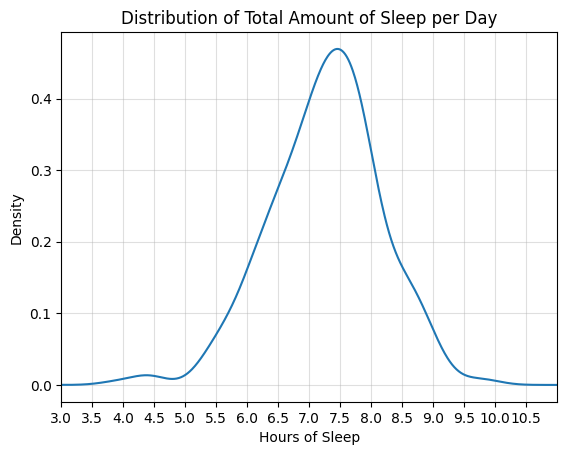

In [201]:
x_min = min(sec_to_hours(bio_sleep_df['total_sleep_duration']))
x_max = max(sec_to_hours(bio_sleep_df['total_sleep_duration']))
sec_to_hours(bio_sleep_df['total_sleep_duration']).plot(kind = 'kde')
plt.title('Distribution of Total Amount of Sleep per Day')
plt.xlabel('Hours of Sleep')
plt.xticks(np.arange(round(x_min - 1), round(x_max + 1), 0.5))
plt.xlim(round(x_min - 1), round(x_max + 1))
plt.grid(alpha = 0.4)

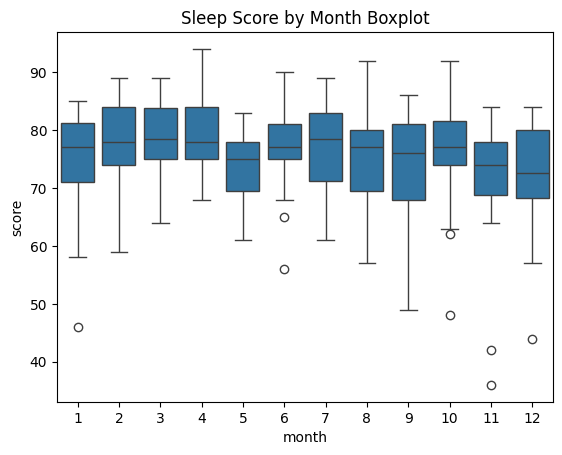

In [202]:
ax = sns.boxplot(x = bio_sleep_df['day'].dt.month, y = daily_sleep_score_df['score'])
ax.set(title = 'Sleep Score by Month Boxplot', xlabel = 'month')
plt.show()

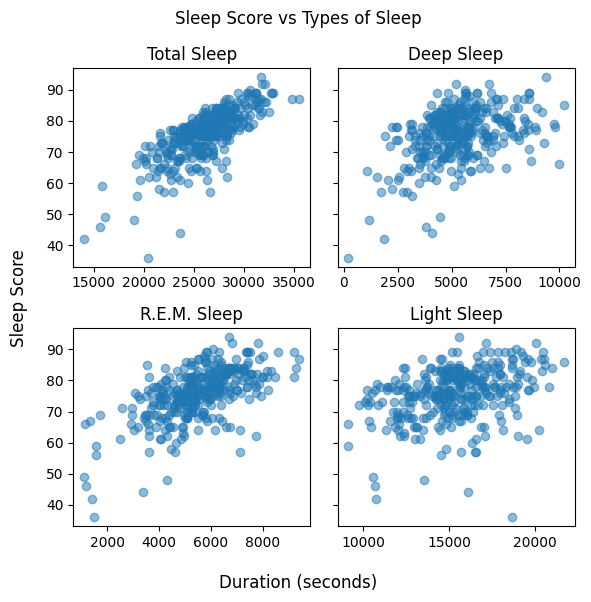

In [357]:
fig, ax = plt.subplots(2,2, figsize = (6, 6), sharey = True)

ax[0, 0].scatter(bio_sleep_df['total_sleep_duration'], daily_sleep_score_df['score'], alpha = 0.5)
ax[0, 0].set_title('Total Sleep')
ax[0, 1].scatter(bio_sleep_df['deep_sleep_duration'], daily_sleep_score_df['score'], alpha = 0.5)
ax[0, 1].set_title('Deep Sleep')
ax[1, 0].scatter(bio_sleep_df['rem_sleep_duration'], daily_sleep_score_df['score'], alpha = 0.5)
ax[1, 0].set_title('R.E.M. Sleep')
ax[1, 1].scatter(bio_sleep_df['light_sleep_duration'], daily_sleep_score_df['score'], alpha = 0.5)
ax[1, 1].set_title('Light Sleep')

fig.suptitle('Sleep Score vs Types of Sleep')
fig.supxlabel('Duration (seconds)')
fig.supylabel('Sleep Score')
fig.tight_layout()

In [203]:
bio_sleep_df['steps'].describe()

count      334.00000
mean     10810.94012
std       3488.07785
min       1601.00000
25%       8449.75000
50%      10549.00000
75%      12689.75000
max      23382.00000
Name: steps, dtype: float64

In [204]:
# Remove day column in preparation for model training.
bio_sleep_df.drop(['day'], axis = 1, inplace = True)

<Axes: >

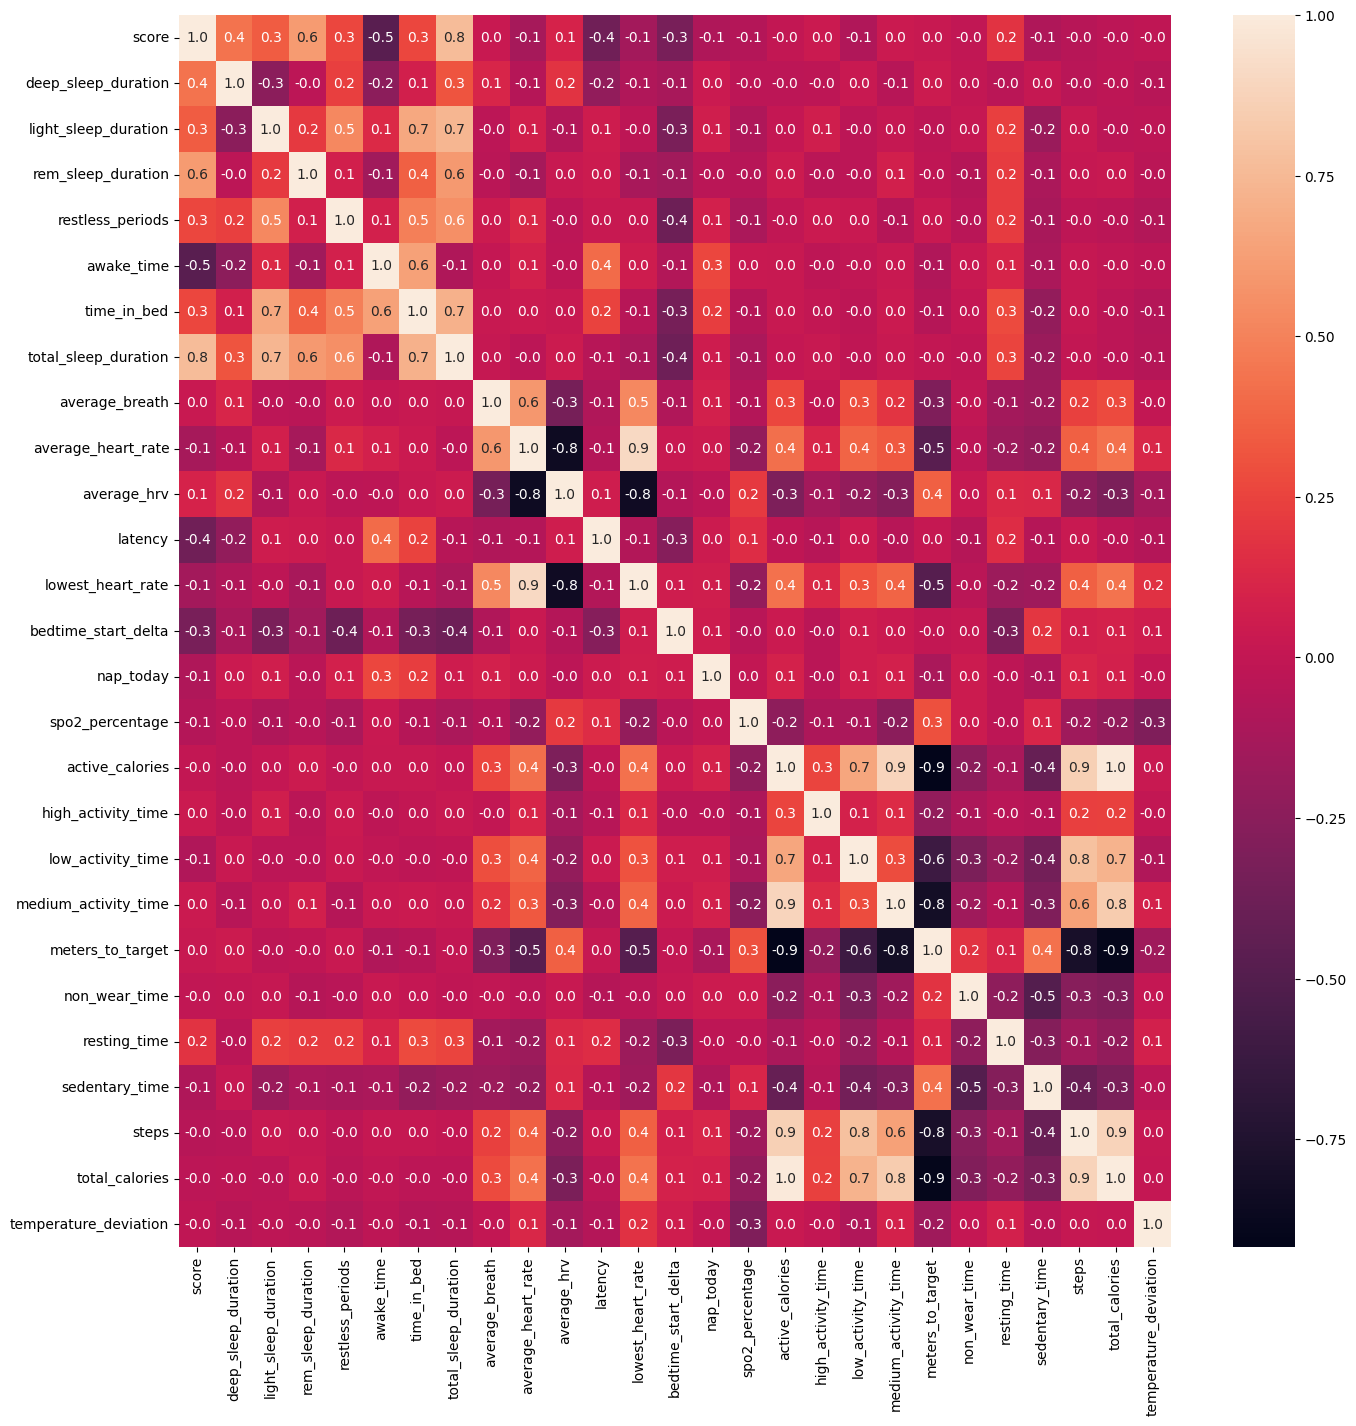

In [205]:
# Correlation
# Include score column to see correlation between response and predictors too.
corr_matrix = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1).corr()
# Plot matrix.
fig, ax = plt.subplots(figsize = (16, 16))
sns.heatmap(corr_matrix, ax = ax, annot = True, fmt = '.1f')

[ ANALYSIS HERE ]

In [249]:
# Create dataframe in the format usable for statsmodels >> ols()
ols_format_df = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1)

In [248]:
bio_sleep_df[['bedtime_start_delta']].describe()

,bedtime_start_delta
count,333.000000
mean,-1207.285285
std,3294.352425
min,-14398.000000
25%,-3150.000000
50%,-1140.000000
75%,632.000000
max,13351.000000


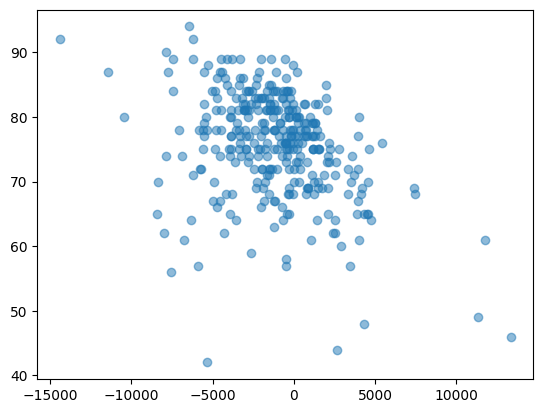

In [269]:
plt.scatter(ols_format_df['bedtime_start_delta'], ols_format_df['score'], alpha = 0.5)

In [266]:
2500 / 60

41.666666666666664

In [282]:
ols_format_df[ols_format_df['bedtime_start_delta'] < 0].std()

score                       7.662709
deep_sleep_duration      1719.839608
light_sleep_duration     2439.097947
rem_sleep_duration       1479.569983
restless_periods           53.039794
awake_time               2670.911971
average_breath              0.445980
average_hrv                25.541994
latency                  1235.928523
bedtime_start_delta      2323.046204
nap_today                   0.270250
spo2_percentage             0.768241
high_activity_time        168.433543
low_activity_time        4691.217443
medium_activity_time     2042.205185
non_wear_time            5486.568030
resting_time             4381.222288
sedentary_time           6541.783993
temperature_deviation       0.221171
dtype: float64

In [281]:
ols_format_df[ols_format_df['bedtime_start_delta'] > 0].std()

score                       7.908613
deep_sleep_duration      1467.537352
light_sleep_duration     2262.810892
rem_sleep_duration       1354.150823
restless_periods           49.424514
awake_time               3203.632035
average_breath              0.498042
average_hrv                25.730293
latency                   647.980972
bedtime_start_delta      2331.835495
nap_today                   0.370130
spo2_percentage             0.800208
high_activity_time         97.625659
low_activity_time        5044.835462
medium_activity_time     1418.780702
non_wear_time            7808.386151
resting_time             4986.286447
sedentary_time           6870.077498
temperature_deviation       0.179423
dtype: float64

In [312]:
late_bedtime_scores = ols_format_df[ols_format_df['bedtime_start_delta'] > 0]['score']
early_bedtime_scores = ols_format_df[ols_format_df['bedtime_start_delta'] < 0]['score']
# As our intention is a two-sample t-test we need to verify if our sample variances indicate equal population variances.
# We can do this with an F-test, IF the samples come from a normal distribution.
# Let's test if our samples display normality with the shapiro-wilk test.
# Null hypothesis H_0: samples come from a normal distribution.
t_stat_sw, p_value_sw = stats.shapiro(ols_format_df['score'])
if p_value_sw > 0.05:
    print(f"Shapiro-Wilk test (Normality): \n{'':<5}with a p-value of {p_value_sw}, \n{'':<5}we fail to reject the null hypothesis: samples are from a normally distributed population.")
else:
    print(f"Shapiro-Wilk test (Normality): \n{'':<5}with a p-value of {p_value_sw}, \n{'':<5}we successfully reject the null hypothesis: samples are from a normally distributed population.")

# We can't use the F-test under these circumstances, but can instead use the levene test to test for equal variances.
# Null hypothesis H_0: Var(late) == Var(early)
t_stat_lev, p_value_lev = stats.levene(late_bedtime_scores, early_bedtime_scores)
p_value_lev
if p_value_lev > 0.05:
    print(f"Levene test (variance): \n{'':<5}with a p-value of {p_value_lev}, \n{'':<5}we fail to reject the null hypothesis: Var(late) == Var(early)")
else:
    print(f"Levene test (variance): \n{'':<5}with a p-value of {p_value_lev}, \n{'':<5}we successfully reject the null hypothesis: Var(late) == Var(early)")

# Finally let's perform a t-test to see if the mean scores are equal or not depending on the sleep time.
# Null hypothesis H_0: mean(late) == mean(early)
t_stat_t, p_value_t = stats.ttest_ind(late_bedtime_scores, early_bedtime_scores, alternative = 'two-sided')
if p_value_t > 0.05:
    print(f"Two-Sample T-test (mean): \n{'':<5}with a p-value of {p_value_t}, \n{'':<5}we fail to reject the null hypothesis: mean(late) == mean(early)")
else:
    print(f"Two-Sample T-test (mean): \n{'':<5}with a p-value of {p_value_t}, \n{'':<5}we successfully reject the null hypothesis: mean(late) == mean(early)")

Shapiro-Wilk test (Normality): 
     with a p-value of 2.4731393821753045e-08, 
     we successfully reject the null hypothesis: samples are from a normally distributed population.
Levene test (variance): 
     with a p-value of 0.9725614929438662, 
     we fail to reject the null hypothesis: Var(late) == Var(early)
Two-Sample T-test (mean): 
     with a p-value of 1.805145414817464e-08, 
     we successfully reject the null hypothesis: mean(late) == mean(early)


Let's fit a linear regression model to the `['score']` response. This should help us identify important features and give a good idea how well our data will be in creating an accurate model.

In [206]:
# Create predictors list for model
# Remove first column (score)
ols_predictors = (ols_format_df.columns[1:]).to_list()
ols_pred_string = ''
for i in ols_predictors:
    ols_pred_string = f'{ols_pred_string} + {i}'

linear_clf = smf.ols(formula = f'score ~ {ols_pred_string[3:]}', data = ols_format_df).fit()
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     94.95
Date:                Mon, 05 Feb 2024   Prob (F-statistic):          7.51e-129
Time:                        12:09:51   Log-Likelihood:                -822.23
No. Observations:                 334   AIC:                             1696.
Df Residuals:                     308   BIC:                             1796.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               -16.1615     31.345     -0.516      0.606     -77.838      45.515
deep_sleep_duration      -0.0005      0.001     -0.563      0.574      -0.002       0.001
light_sleep_duration     -0.0014      0.001     -1.448      0.149      -0.003       0.000
rem_sleep_duration    -5.424e-05      0.001     -0.057      0.954      -0.002       0.002
restless_periods         -0.0202      0.004     -4.707      0.000      -0.029      -0.012
awake_time               -0.0054      0.004     -1.432      0.153      -0.013       0.002
time_in_bed               0.0047      0.004      1.254      0.211      -0.003       0.012
total_sleep_duration     -0.0020      0.003     -0.694      0.488      -0.008       0.004
average_breath            0.5308      0.505      1.051      0.294      -0.463       1.524
average_heart_rate       -0.1130      0.073     -1.559      0.120      -0.256       0.030
average_hrv              -0.0129      0.015     -0.867      0.386      -0.042       0.016
latency                  -0.0021      0.000    -11.660      0.000      -0.002      -0.002
lowest_heart_rate         0.0072      0.062      0.117      0.907      -0.114       0.128
bedtime_start_delta      -0.0006   6.36e-05     -8.646      0.000      -0.001      -0.000
nap_today                -0.5965      0.563     -1.059      0.290      -1.705       0.512
spo2_percentage           0.3224      0.236      1.364      0.174      -0.143       0.787
active_calories          -0.0028      0.010     -0.275      0.783      -0.023       0.017
high_activity_time        0.0006      0.001      0.377      0.706      -0.002       0.003
low_activity_time        -0.0002      0.000     -0.752      0.453      -0.001       0.000
medium_activity_time     -0.0003      0.001     -0.664      0.507      -0.001       0.001
meters_to_target      -7.495e-05      0.000     -0.716      0.475      -0.000       0.000
non_wear_time           8.08e-05      0.000      0.630      0.529      -0.000       0.000
resting_time              0.0001      0.000      1.120      0.264   -9.64e-05       0.000
sedentary_time         7.258e-05      0.000      0.519      0.604      -0.000       0.000
steps                  1.701e-05      0.000      0.142      0.887      -0.000       0.000
total_calories            0.0077      0.009      0.813      0.417      -0.011       0.026
temperature_deviation     0.6534      0.883      0.740      0.460      -1.084       2.391
==============================================================================
Omnibus:                       20.522   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.711
Skew:                          -0.489   Prob(JB):                     1.58e-06
Kurtosis:                       3.981   Cond. No.                  

#### Feature Selection/Removal

In [207]:
# Remove sign on correlation score for comparison.
# TODO: This method arbitrarily selects the first feature (of the two with a high score)
#   that it comes across. Change this method to have an insight-based selection method.
#   Possibly a preference list.
corr_matrix_abs = corr_matrix.abs()
# Drop score from x and y axis.
corr_matrix_abs.drop('score', axis = 0, inplace = True)
corr_matrix_abs.drop('score', axis = 1, inplace = True)
# Mask off only one of the correlation triangles to avoid duplicates.
corr_triangle = corr_matrix_abs.where(np.triu(np.ones(corr_matrix_abs.shape), k = 1).astype(bool))
# Create list of features with correlation higher than a threshold.
# Threshold set to > 0.75
to_drop = [column for column in corr_triangle.columns if any(corr_triangle[column] > 0.7)]
print(to_drop)

['total_sleep_duration', 'average_hrv', 'lowest_heart_rate', 'medium_activity_time', 'meters_to_target', 'steps', 'total_calories']


For now let's manually remove features (see TODO note above).

In [208]:
choices_to_drop = [('average_hrv', 'average_heart_rate'), # average_heart
           ('lowest_heart_rate', 'average_hrv'), # average hrv
           ('medium_activity_time', 'active_calories'), # active
           ('meters_to_target', 'active_calories'), # both
           ('steps', 'alot'), # steps
           ('total_calories', 'alot')] # total calories

bio_sleep_df.drop(['lowest_heart_rate', 
                   'active_calories', 
                   'meters_to_target', 
                   'steps', 
                   'total_calories', 
                   'average_heart_rate', 
                   'time_in_bed', 
                   'total_sleep_duration'],
                  axis = 1, inplace = True)

<Axes: >

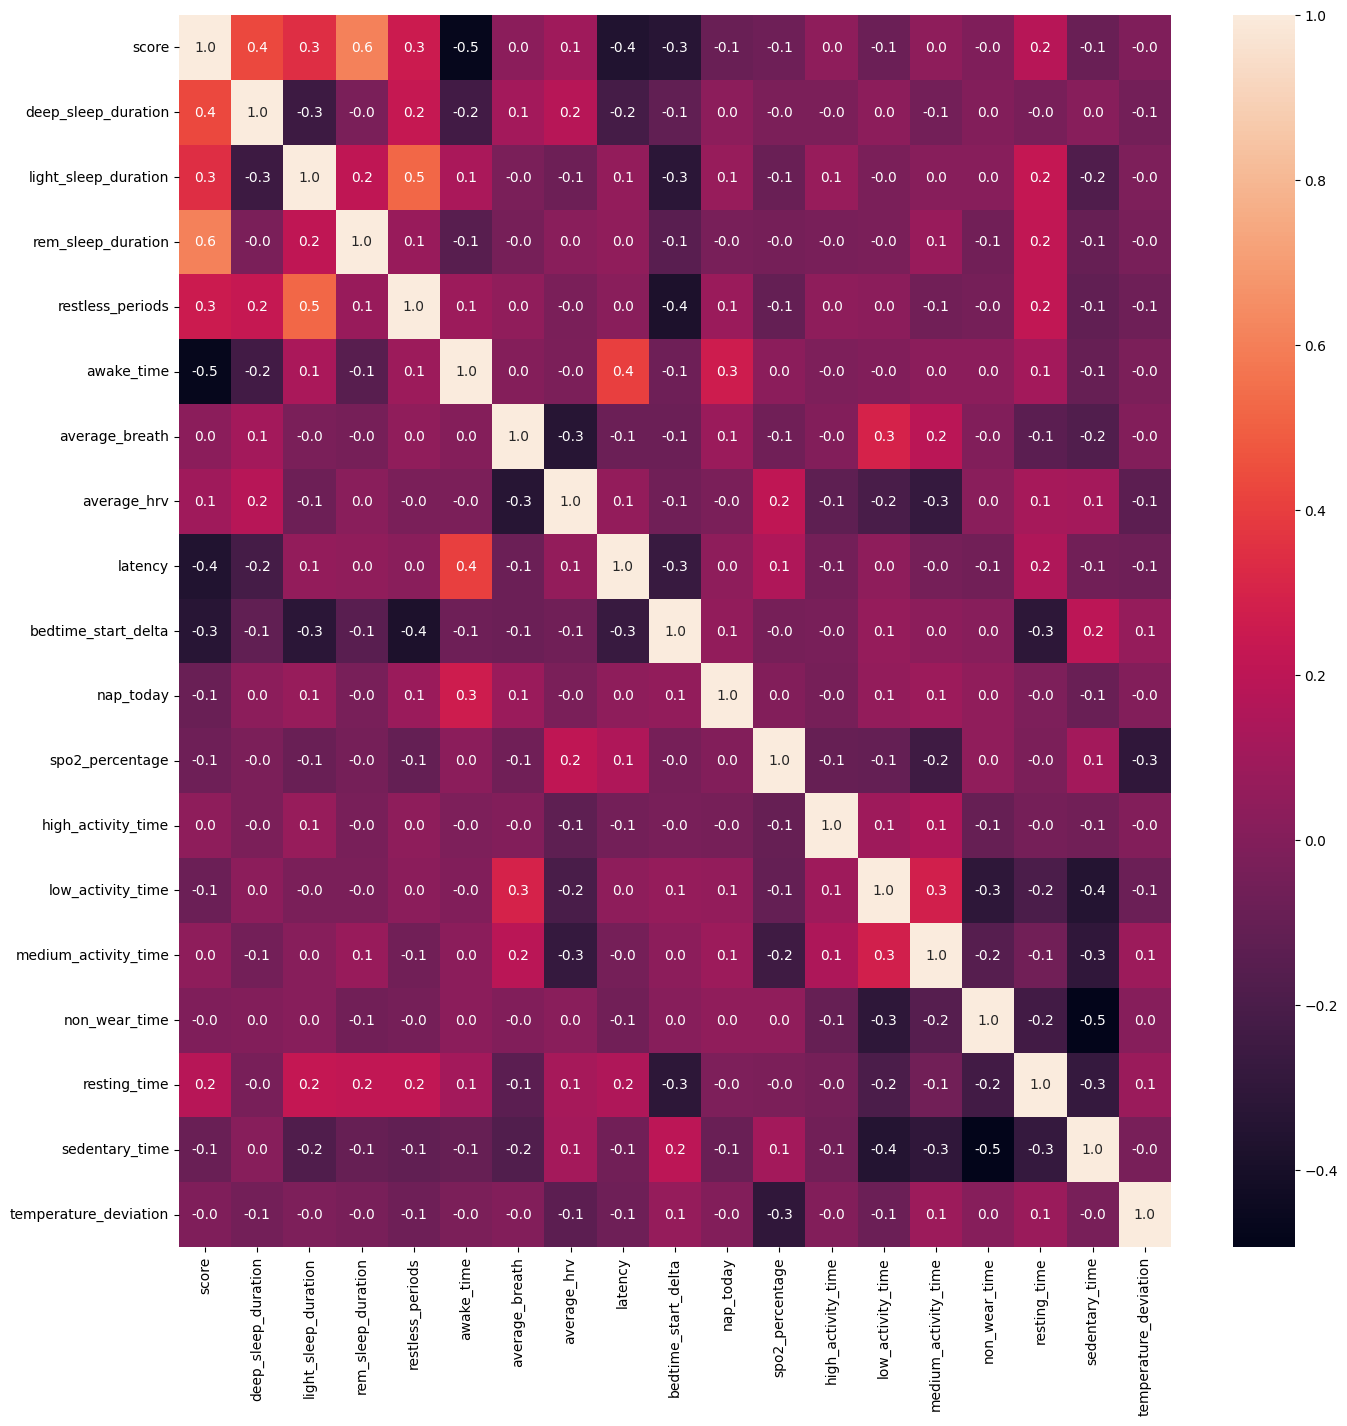

In [209]:
# Correlation
# Include score column to see correlation between response and predictors too.
corr_matrix = pd.concat([daily_sleep_score_df['score'], bio_sleep_df], axis = 1).corr()
# Plot matrix.
fig, ax = plt.subplots(figsize = (16, 16))
sns.heatmap(corr_matrix, ax = ax, annot = True, fmt = '.1f')

Subset Feature Selection / Backwards Feature Selection starting from all features.

In [210]:
# Move this about feature removal and maybe make yet another DF set for recursive optimization vs manual feature removal.

#### Outlier Removal

In [211]:
display(daily_sleep_score_df['score_bin_even'].value_counts()==1)

score_bin_even
70.5 to 80.5     False
80.5 to 90.5     False
60.5 to 70.5     False
50.5 to 60.5     False
40.5 to 50.5     False
90.5 to 100.5    False
30.5 to 40.5      True
Name: count, dtype: bool

In [212]:
display(daily_sleep_score_df['score_bin_even'].value_counts())
# Remove outlier for now so we can class-balance the splits (min per class required = 2)
# TODO: Remove hardcoded solution, get counts and delete if == 1 in case of new data.
#       (Maybe use daily_sleep_score_df['score_bin'].value_counts() == 1)
class_outlier_loc = daily_sleep_score_df.loc[daily_sleep_score_df['score_bin_even'] == '30.5 to 40.5']
print(class_outlier_loc)
daily_sleep_score_df.drop(class_outlier_loc.index, axis = 0, inplace = True)
bio_sleep_df.drop(class_outlier_loc.index, axis = 0, inplace = True)

daily_sleep_score_df.reset_index(drop = True, inplace = True)
bio_sleep_df.reset_index(drop = True, inplace = True)

score_bin_even
70.5 to 80.5     155
80.5 to 90.5      98
60.5 to 70.5      65
50.5 to 60.5       7
40.5 to 50.5       5
90.5 to 100.5      3
30.5 to 40.5       1
Name: count, dtype: int64

     score score_bin_even score_bin_quantile score_bin_custom
285     36   30.5 to 40.5              Worst            Worst


#### Standardize Features
Since we'll be using many machine learning models in which regularization techniques are sensitive to differences in predictor variance magnitudes/scale (e.g., Lasso/Ridge Regression, SVM, etc.) and expect features to be roughly normally distributed, we will be standardizing features appropriately.

Standardization will be done with the following formula:


$$Z = \frac{(X - \bar{X})}{S}$$

Centers inputs around 0 with the sample mean, and scales them with the sample standard deviation.


##### Train Test Split

Since we'll be using sklearn's StandardScaler() to standardize, we need to do the split at the same time so that we can properly separate the training information from the test set during standardization, preventing data leakage.

In total we will have 3 types of train / test splits to use on our models, but they will be split identically. We can also use the `stratify` parameter to class balance the training and test sets which will help generalize models training on this fairly sparse dataset.

In [213]:
rand_state = 93285 #472453 #98784 # Used in all classifiers
test_ratio = 0.2
bin_type = 'score_bin_quantile'

# Discretized Scores
# Stratify-balance the classes with the bin column (note this will slightly alter regression scores too).
X_train, X_test, y_train, y_test = train_test_split(bio_sleep_df, daily_sleep_score_df, 
                                                    test_size = test_ratio, 
                                                    random_state = rand_state)#, 
                                                    #stratify = daily_sleep_score_df['score_bin_custom'])

# Binned/Categorical Class Labels
y_train_bin, y_test_bin = y_train[bin_type], y_test[bin_type]

# Centered and Standardized
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = scaler.get_feature_names_out())
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = scaler.get_feature_names_out())
# Squeeze y's to put into a series, same format as train_test_split
y_train_scaled = pd.DataFrame(scaler.fit_transform(np.array(y_train['score']).reshape(-1, 1)), columns = ['score_scaled']).squeeze(axis = 1)
y_test_scaled = pd.DataFrame(scaler.transform(np.array(y_test['score']).reshape(-1, 1)), columns = ['score_scaled']).squeeze(axis = 1)

# Create a centered and standardized DF for regression model.
bio_sleep_df_scaled = pd.DataFrame(scaler.fit_transform(bio_sleep_df), columns = scaler.get_feature_names_out())

daily_sleep_score_df['score_scaled'] = (pd.DataFrame(scaler.fit_transform(np.array(daily_sleep_score_df['score']).reshape(-1, 1))))
display(daily_sleep_score_df)

,score,score_bin_even,score_bin_quantile,score_bin_custom,score_scaled
0,81,80.5 to 90.5,Good,Above Avg,0.641282
1,81,80.5 to 90.5,Good,Above Avg,0.641282
2,89,80.5 to 90.5,Best,Good,1.629353
3,78,70.5 to 80.5,Above Avg,Above Avg,0.270755
4,80,70.5 to 80.5,Above Avg,Above Avg,0.517773
...,...,...,...,...,...
328,77,70.5 to 80.5,Below Avg,Below Avg,0.147246
329,85,80.5 to 90.5,Best,Good,1.135317
330,64,60.5 to 70.5,Worst,Worst,-1.458369
331,77,70.5 to 80.5,Below Avg,Below Avg,0.147246


After standardization and feature removal let's see if the regression has changed.

In [214]:
# Create dataframe in the format usable for statsmodels >> ols()
ols_format_df_scaled = pd.concat([daily_sleep_score_df['score_scaled'], bio_sleep_df_scaled], axis = 1)

ols_predictors = (ols_format_df_scaled.columns[1:]).to_list()
ols_pred_string = ''
for i in ols_predictors:
    ols_pred_string = f'{ols_pred_string} + {i}'

linear_clf = smf.ols(formula = f'score_scaled ~ {ols_pred_string[3:]}', data = ols_format_df_scaled).fit()
linear_clf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           score_scaled   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.869
Method:                 Least Squares   F-statistic:                     123.3
Date:                Mon, 05 Feb 2024   Prob (F-statistic):          1.66e-130
Time:                        12:09:52   Log-Likelihood:                -124.82
No. Observations:                 333   AIC:                             287.6
Df Residuals:                     314   BIC:                             360.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              3.476e-16      0.020   1.75e-14      1.000      -0.039       0.039
deep_sleep_duration       0.4394      0.025     17.450      0.000       0.390       0.489
light_sleep_duration      0.4140      0.028     14.913      0.000       0.359       0.469
rem_sleep_duration        0.4868      0.022     22.551      0.000       0.444       0.529
restless_periods         -0.1368      0.027     -4.978      0.000      -0.191      -0.083
awake_time               -0.2390      0.023    -10.328      0.000      -0.285      -0.193
average_breath            0.0050      0.023      0.218      0.827      -0.040       0.050
average_hrv               0.0227      0.023      0.979      0.328      -0.023       0.068
latency                  -0.2745      0.024    -11.606      0.000      -0.321      -0.228
bedtime_start_delta      -0.2276      0.025     -9.075      0.000      -0.277      -0.178
nap_today                -0.0104      0.021     -0.496      0.620      -0.052       0.031
spo2_percentage           0.0316      0.022      1.426      0.155      -0.012       0.075
high_activity_time        0.0291      0.022      1.332      0.184      -0.014       0.072
low_activity_time         0.0029      0.070      0.041      0.967      -0.136       0.141
medium_activity_time      0.0607      0.036      1.703      0.090      -0.009       0.131
non_wear_time             0.0741      0.092      0.806      0.421      -0.107       0.255
resting_time              0.0817      0.064      1.274      0.203      -0.044       0.208
sedentary_time            0.0902      0.099      0.910      0.364      -0.105       0.285
temperature_deviation     0.0159      0.021      0.739      0.460      -0.026       0.058
==============================================================================
Omnibus:                       21.690   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.866
Skew:                          -0.535   Prob(JB):                     1.47e-06
Kurtosis:                       3.890   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[ ANALYSIS ]

Note the condition number! Standardization and removal of features made quite the difference in multicollinearity there.

### Helper Functions

In [215]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['max_depth']), len(grid.param_grid['max_leaf_nodes']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('max_leaf_nodes')
    plt.ylabel('max_depth')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['max_leaf_nodes'])), grid.param_grid['max_leaf_nodes'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['max_depth'])), grid.param_grid['max_depth'])
    plt.title('Validation accuracy')
    plt.show()

def plotSearchGridSVM(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid['C']), len(grid.param_grid['gamma']))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('Gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid['gamma'])), grid.param_grid['gamma'], rotation=90)
    plt.yticks(np.arange(len(grid.param_grid['C'])), grid.param_grid['C'])
    plt.title('Validation accuracy')
    plt.show()

### Model Selection

---

Something we haven't discussed yet, besides in the realm of feature engineering, is whether or not regression or logistic regression makes more sense for this type of problem. 

First thing to note, because this isn't a binary logistic classification problem since we've binned our target variable into multiple classes the way we handle this is important and the sklearn package handles each model a little differently. Methods we'll use to handle multi-class, sometimes called multinomial, classification problem is to utilize One-vs-Rest, One-vs-One, and Multinomial Loss (aka Cross Entropy) techniques. These methods will handle this issue of multiple classes fine, but we need to ask what we're looking for out of this.

Given the predictor variables and expected prediction, are we expecting a:
- Precise, continuous or discrete, sleep score predictions (Regression)?
  - How do we measure a successful prediction?
    - Is the standard error of each $\hat{y_i}$ within a range of the ground truth $y_i$.
    - Root Mean Squared Error (RMSE)
    - Mean Absolute Error (MAE)
- Predicted classes of sleep quality given by binned sleep scores indicating different levels of 'Bad', 'Good', 'Better', 'Best' sleep.
  - How do we measure a successful prediction?
    - Accuracy
    - F1 Score
    - ROC Curve

It's very important to note that comparing regression and classification models is almost always a fools-errand in building a convincing metric that can relate between the two types of models. In practice, it's better to properly formulate the question beforehand and fit the models that better answer that question instead of fitting them all and attempting to compare things that can't be directly compared.

All that said, because this is just an exercise, let's go ahead and do just that by creating a few of each of regression and logistic regression models and discuss this further in the results section.

In [216]:
# Initialize list of fit model objects.
models_regression = []
models_classification = []

#### Linear Regression / Logistic Classification

In [217]:
mod_log_regression = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial', max_iter = 15000, random_state = rand_state).fit(X_train, y_train_bin)
models_classification.append(mod_log_regression)
print(mod_log_regression.score(X_test, y_test_bin))

mod_lin_regression = LinearRegression().fit(X_train, y_train['score'])
models_regression.append(mod_lin_regression)
print(mod_lin_regression.score(X_test, y_test['score']))

mod_ridge_regression = Ridge(max_iter = 10000, random_state = rand_state).fit(X_train, y_train['score'])
models_regression.append(mod_ridge_regression)
print(mod_ridge_regression.score(X_test, y_test['score']))

mod_ridge_classifier = RidgeClassifier(max_iter = 10000, random_state = rand_state).fit(X_train, y_train_bin)
models_classification.append(mod_ridge_classifier)
print(mod_ridge_classifier.score(X_test, y_test_bin))

mod_lasso_regression = Lasso(max_iter = 10000, random_state = rand_state).fit(X_train, y_train['score'])
models_regression.append(mod_lasso_regression)
print(mod_lasso_regression.score(X_test, y_test['score']))

0.5671641791044776
0.8764441628360964
0.8765403288269993
0.5074626865671642
0.8778868972783462


#### Support Vector Machine (SVM)

For hyperparameter tuning we will use a grid search with a range of C and Gamma values, and apply 3-fold cross-validation.

In [218]:
params = {'C': np.logspace(6, 10, base = 2), 'gamma': np.logspace(-10, 0, base = 2)}
grid_svm_regression = GridSearchCV(SVR(kernel = 'rbf'), param_grid = params, cv = 3).fit(X_train_scaled, y_train['score'])
mod_svm_regression = grid_svm_regression.best_estimator_
models_regression.append(mod_svm_regression)

grid_svm_classifier = GridSearchCV(SVC(kernel = 'rbf', random_state = rand_state, probability = True), param_grid = params, cv = 3).fit(X_train_scaled, y_train_bin)
mod_svm_classifier = grid_svm_classifier.best_estimator_
models_classification.append(mod_svm_classifier)

In [219]:
print(mod_svm_regression.score(X_test_scaled, y_test['score']))
print(mod_svm_classifier.score(X_test_scaled, y_test['score_bin_quantile']))

0.9223142319703853
0.6567164179104478


In [220]:
print(mean_squared_error(y_test['score'], mod_svm_regression.predict(X_test_scaled), squared = False))
print(mean_absolute_error(y_test['score'], mod_svm_regression.predict(X_test_scaled)))

2.536414629808979
2.0419129251842323


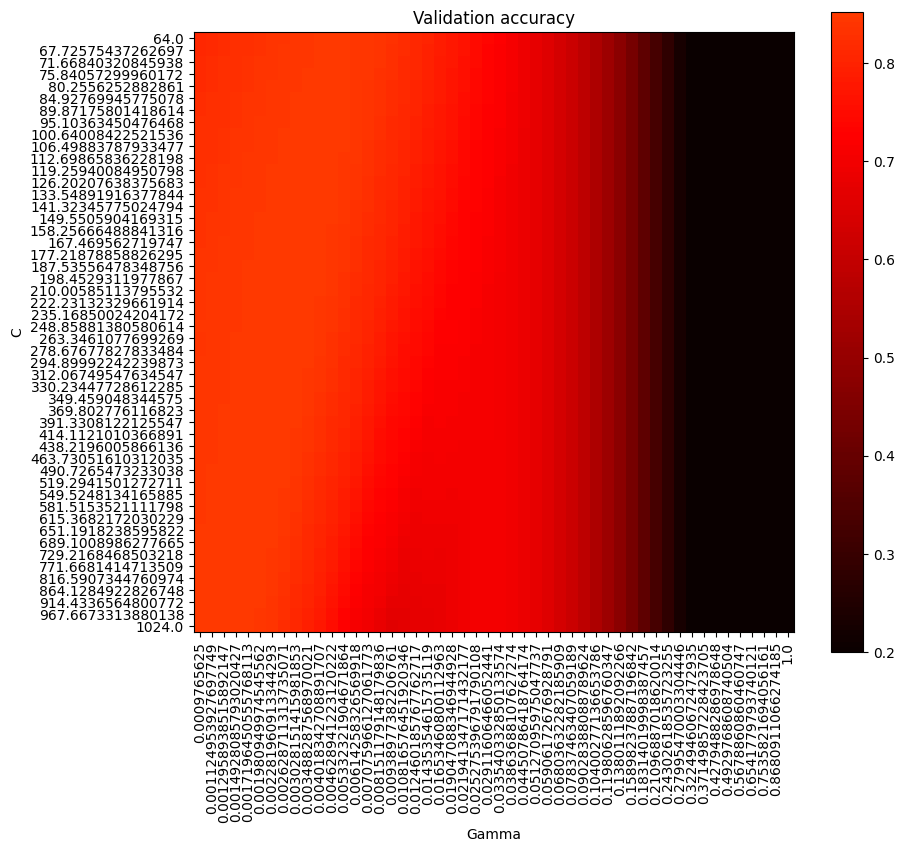

GridSearch results indicate the optimized parameters are, 
C: 864.1284922826748, Gamma: 0.0017196450555768113, Validation Accuracy: 0.8517615237394035
0.9104477611940298


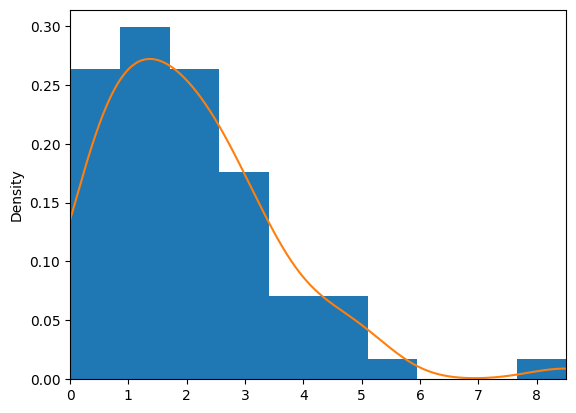

In [221]:
plotSearchGridSVM(grid_svm_regression)

scores = [x for x in grid_svm_regression.cv_results_["mean_test_score"]]

max_index = scores.index(max(scores))
max_score = max(scores)
opt_C = grid_svm_regression.cv_results_['param_C'][max_index]
opt_Gamma = grid_svm_regression.cv_results_['param_gamma'][max_index]

print(f'GridSearch results indicate the optimized parameters are, \nC: {opt_C}, Gamma: {opt_Gamma}, Validation Accuracy: {max_score}')

# OR use the attribute .best_params_
grid_svm_regression.best_params_

results_svm = list(zip(grid_svm_regression.predict(X_test_scaled), y_test['score']))
pred_delta_svm = [abs(pred - truth) for pred, truth in results_svm]
plt.hist(pred_delta_svm, density = True)
pd.Series(pred_delta_svm).plot(kind = 'kde')
plt.xlim(0, max(pred_delta_svm))
print((np.array(pred_delta_svm) <= 4).sum() / len(pred_delta_svm))

#### Decision Trees

In [222]:
dt_classifier = DecisionTreeClassifier(max_depth = None, max_leaf_nodes = None, random_state = rand_state).fit(X_train, y_train_bin)
models_classification.append(dt_classifier)
print(dt_classifier.score(X_train, y_train_bin))
print(dt_classifier.score(X_test, y_test_bin))
#path = dt_classifier.cost_complexity_pruning_path(X_train, y_train)
#ccp_alphas, impurities = path.ccp_alphas, path.impurities

1.0
0.2835820895522388


##### AdaBoost

---



In [223]:
adaboost_classifier = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1),
                   n_estimators = 100,
                   random_state = rand_state,
                   learning_rate = 0.5
                   ).fit(X_train, y_train_bin)
models_classification.append(adaboost_classifier)
print(adaboost_classifier.score(X_test, y_test_bin))
results_adaboost = list(zip(adaboost_classifier.predict(X_test), y_test['score']))
# pred_delta_adaboost = [abs(pred - truth) for pred, truth in results_adaboost]
# plt.hist(pred_delta_adaboost)
# print((np.array(pred_delta_adaboost) <= 5).sum() / len(pred_delta_adaboost))

0.3582089552238806


##### Random Forest

---


In [224]:
params = {'max_depth': np.linspace(1, 25, 25, dtype = int), 'max_leaf_nodes': np.linspace(2, 98, 25, dtype = int)}
grid_random_forest = GridSearchCV(RandomForestClassifier(random_state=rand_state), 
                    param_grid = params, 
                    cv = 3, 
                    verbose = 3, 
                    n_jobs = -1
                    ).fit(X_train, y_train['score'])
mod_random_forest = grid_random_forest.best_estimator_
models_regression.append(mod_random_forest)

Fitting 3 folds for each of 625 candidates, totalling 1875 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


[CV 2/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.067 total time=   0.0s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.067 total time=   0.0s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.080 total time=   0.1s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.079 total time=   0.1s
[CV 1/3] END .....max_depth=1, max_leaf_nodes=6;, score=0.079 total time=   0.1s
[CV 3/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.080 total time=   0.1s
[CV 2/3] END .....max_depth=1, max_leaf_nodes=2;, score=0.067 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.079 total time=   0.1s
[CV 3/3] END ....max_depth=1, max_leaf_nodes=10;, score=0.080 total time=   0.0s
[CV 2/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.067 total time=   0.0s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=14;, score=0.079 total time=   0.1s
[CV 1/3] END ....max_depth=1, max_leaf_nodes=18;, score=0.079 total time=   0.1s
[CV 2/3] END ....max_depth=1

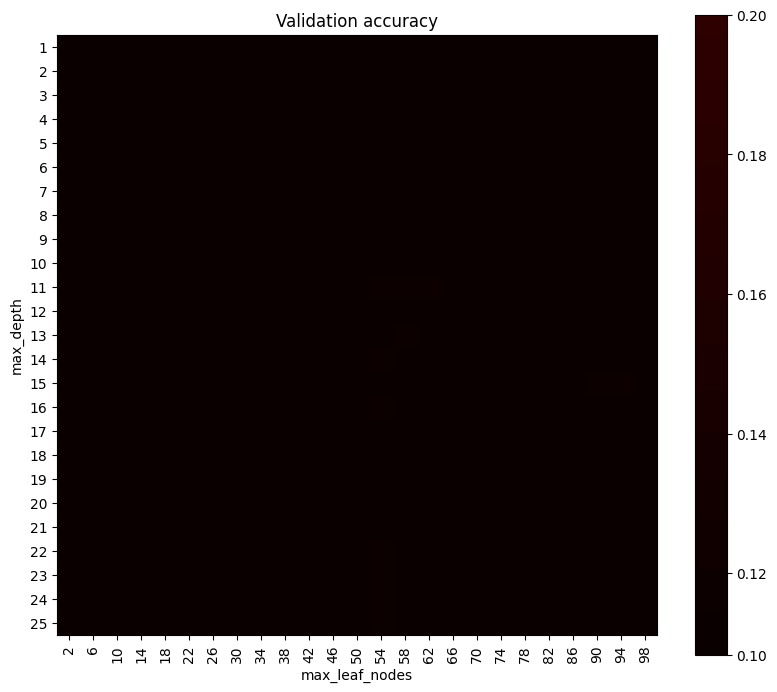

In [225]:
plotSearchGrid(grid_random_forest)

0.04477611940298507


0.7014925373134329

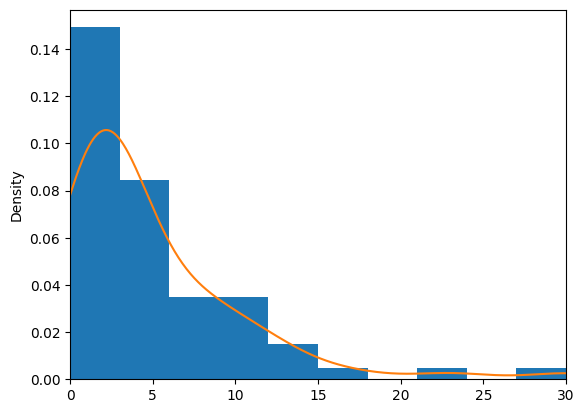

In [226]:
results_rand_forest = list(zip(grid_random_forest.best_estimator_.predict(X_test), y_test['score']))
print(grid_random_forest.best_estimator_.score(X_test, y_test['score']))

pred_delta_rand_forest = [abs(pred - truth) for pred, truth in results_rand_forest]
plt.hist(pred_delta_rand_forest, density = True)
pd.Series(pred_delta_rand_forest).plot(kind = 'kde')
plt.xlim(0, max(pred_delta_rand_forest))
(np.array(pred_delta_rand_forest) <= 5).sum() / len(pred_delta_rand_forest)

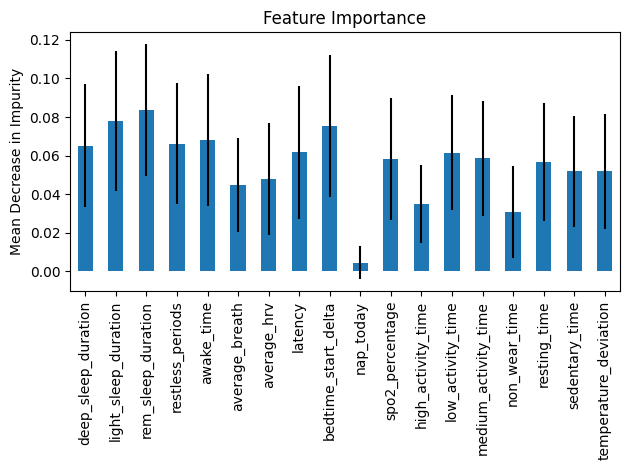

In [227]:
feat_importance = grid_random_forest.best_estimator_.feature_importances_
feat_imp_std = np.std([tree.feature_importances_ for tree in grid_random_forest.best_estimator_.estimators_], axis = 0)
forest_importances = pd.Series(feat_importance, index=bio_sleep_df.columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr = feat_imp_std, ax = ax)
ax.set_title("Feature Importance")
ax.set_ylabel("Mean Decrease in Impurity")
fig.tight_layout()

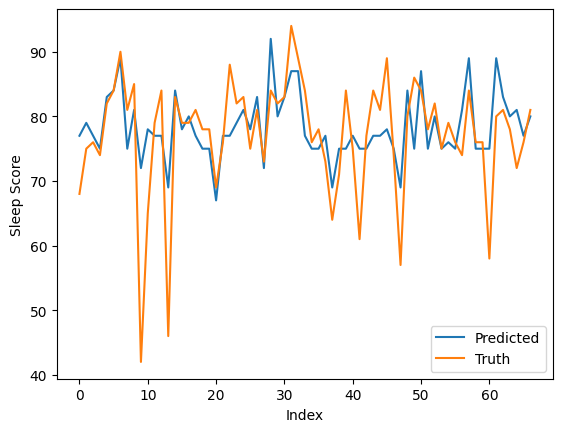

In [228]:
plt.plot(results_rand_forest, label = ['Predicted', 'Truth'])
plt.xlabel('Index')
plt.ylabel('Sleep Score')
plt.plot()
plt.legend()

### Results

---



In [229]:
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize, LabelBinarizer
from sklearn.metrics import RocCurveDisplay

In [397]:
# Implement scoring metric functions that iterates through models saved into models list.
def scores_classification(models):
    # Create dictionary to return dataframe of scores.
    model_scores = {}
    print(f'Using binned interval: {bin_type}')
    for i, mod in enumerate(models):
        print(i, '==========================================================')
        # Check if model is the SVC(), uses the scaled features.
        if 'SVC' in str(mod):
            X_test_temp = X_test_scaled
        else:
            X_test_temp = X_test

        model_name = str(mod).partition('(')[0]
        model_score = mod.score(X_test_temp, y_test_bin)
        # Set scores to model in dictionary.
        model_scores[model_name] = {'Accuracy': model_score}

        print(model_name)
        print('Score:', model_score)

    return model_scores

def scores_regression(models):
    # Create dictionary to return dataframe of scores.
    model_scores = {}

    for i, mod in enumerate(models):
        print(i, '==========================================================')
        # Check if model is the SVR(), uses the scaled features.
        if 'SVR' in str(mod):
            X_test_temp = X_test_scaled
        else:
            X_test_temp = X_test

        y_pred = mod.predict(X_test_temp)
        r2 = mod.score(X_test_temp, y_test['score'])
        n , p = X_test_temp.shape # number of samples and predictors
        adj_r2 = 1 - (((1 - r2) * (n - 1)) / (n - p - 1))
        rmse = mean_squared_error(y_test['score'], y_pred, squared = False)
        mae = mean_absolute_error(y_test['score'], y_pred)
        model_name = str(mod).partition('(')[0]
        # Set scores to model in dictionary.
        model_scores[model_name] = {'R2': r2,
                                    'Adj_R2': adj_r2,
                                    'RMSE': rmse,
                                    'MAE': mae}

        print(model_name)
        print(f'R2: {r2} | Adj_R2: {adj_r2}')
        print(f'RMSE: {rmse}')
        print(f'MAE: {mae}')

    return model_scores

def plot_predictions_vs_score_regression(models):
    fig, ax = plt.subplots(int(np.ceil(len(models) / 3)), 3, figsize = (12, 8))
    for i, mod in enumerate(models):
        # Check if model is the SVR(), uses the scaled features.
        if 'SVR' in str(mod):
            X_test_temp = X_test_scaled
        else:
            X_test_temp = X_test

        y_pred = mod.predict(X_test_temp)
        r2 = mod.score(X_test_temp, y_test['score'])
        n , p = X_test_temp.shape # number of samples and predictors
        adj_r2 = 1 - (((1 - r2) * (n - 1)) / (n - p - 1))
        rmse = mean_squared_error(y_test['score'], y_pred, squared = False)
        mae = mean_absolute_error(y_test['score'], y_pred)

        results = list(zip(y_pred, y_test['score']))
        results = sorted(results, key = lambda x: x[1], reverse = True)
        
        ax[i // 3, i % 3].plot(results, alpha = 0.85, drawstyle = 'steps')
        ax[i // 3, i % 3].set_xlabel('Index (sorted)')
        ax[i // 3, i % 3].set_ylabel('Sleep Score')
        ax[i // 3, i % 3].set_title(str(mod).partition('(')[0])
        ax[i // 3, i % 3].grid(alpha = 0.4)
        ax[i // 3, i % 3].text(x = 0.1, 
                            y = 0.2, 
                            transform = ax[i // 3, i % 3].transAxes,
                            s = (f"{mae:0.3f} - MAE"
                            '\n'f"{rmse:0.3f} - RMSE"
                            '\n'f"{r2:0.3f} - R2"
                            '\n'f"{adj_r2:0.3f} - Adj_R2"))
        # Check if odd number of models and delete last subplot if true.
    if len(models) % 2 != 0:
        fig.delaxes(ax[len(models) // 3, (len(models) % 3)])
        
    plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
    fig.legend(['Predicted', 'Truth'], loc = 'upper right')
    fig.suptitle('Predicted Score and True Score', fontsize = 12)

    return None

def plot_obs_vs_pred_regression(models):
    fig, ax = plt.subplots(int(np.ceil(len(models) / 3)), 3, figsize = (11, 7))
    for i, mod in enumerate(models):
        # Check if model is the SVR(), uses the scaled features.
        if 'SVR' in str(mod):
            X_test_temp = X_test_scaled
        else:
            X_test_temp = X_test

        ax[i // 3, i % 3].scatter(mod.predict(X_test_temp), y_test['score'], alpha = 0.5)
        ax[i // 3, i % 3].plot(np.arange(min(y_test['score']), 100, 1), np.arange(min(y_test['score']), 100, 1), 'k--', alpha = 0.6)
        ax[i // 3, i % 3].set_xlabel('Predictions')
        ax[i // 3, i % 3].set_ylabel('Observations')
        ax[i // 3, i % 3].set_title(str(mod).partition('(')[0])
        ax[i // 3, i % 3].grid(alpha = 0.4)

        # Check if odd number of models and delete last subplot if true.
    if len(models) % 2 != 0:
        fig.delaxes(ax[len(models) // 3, (len(models) % 3)])
        
    plt.subplots_adjust(wspace = 0.2, hspace = 0.4)
    fig.suptitle('Observed (Truth) vs Predicted', fontsize = 12)

    return None

# Function to iterate through classification models and plot ROC curves.
def plot_models_roc(models):
    # Need to use LabelBinarizer() since we have multiple classes.
    label_binarizer = LabelBinarizer().fit(y_train_bin)
    y_onehot_test = label_binarizer.transform(y_test_bin)
    for mod in models:
        if 'Ridge' in str(mod): # Can't calculate probabilities in Ridge.
            continue
        if 'SVC' in str(mod): # Use scaled X_test values
            y_scores = mod.predict_proba(X_test_scaled)
        else:
            y_scores = mod.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_onehot_test.ravel(), y_scores.ravel())
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = f"{str(mod).partition('(')[0]} - AUC = {auc_score:0.2f}")

    plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), 'k--')
    plt.title('ROC - Micro-Average OvR')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(alpha = 0.4)
    plt.legend(loc = 'lower right')
    
    return None

# Function to iterate through classification models and plot confusion matrix together.
def plot_models_confusion_matrix(models):
    fig, ax = plt.subplots(int(np.ceil(len(models) / 3)), 3, figsize = (8, 6), sharey = True)
    for i, mod in enumerate(models):
        # Check if model is the SVC(), uses the scaled features.
        if 'SVC' in str(mod):
            X_test_temp = X_test_scaled 
        else:
            X_test_temp = X_test

        cm = confusion_matrix(y_test_bin, mod.predict(X_test_temp), labels = y_test_bin.sort_values().unique())
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = y_test_bin.sort_values().unique())
        disp.plot(ax = ax[i // 3, i % 3], xticks_rotation = 90)
        disp.ax_.set_title(str(mod).partition('(')[0])
        disp.im_.colorbar.remove()

    # Check if odd number of models and delete last subplot if true.
    if len(models) % 2 != 0:
        fig.delaxes(ax[i // 3, (len(models) % 3)])
    fig.tight_layout()
    plt.subplots_adjust(wspace = 0.2, hspace = 0.8)
    fig.colorbar(disp.im_, ax = ax)
    
    return None

In [381]:
regression_scores = scores_regression(models_regression)

0 ==========================================================
LinearRegression
R2: 0.8764441628360964 | Adj_R2: 0.8301107238996325
RMSE: 3.198756279594567
MAE: 2.4649314789948833
1 ==========================================================
Ridge
R2: 0.8765403288269993 | Adj_R2: 0.8302429521371241
RMSE: 3.197511209136072
MAE: 2.465442727171346
2 ==========================================================
Lasso
R2: 0.8778868972783462 | Adj_R2: 0.8320944837577261
RMSE: 3.1800258531185595
MAE: 2.46685039856426
3 ==========================================================
SVR
R2: 0.9223142319703853 | Adj_R2: 0.8931820689592798
RMSE: 2.536414629808979
MAE: 2.0419129251842323
4 ==========================================================
RandomForestClassifier
R2: 0.04477611940298507 | Adj_R2: -0.31343283582089554
RMSE: 7.2821597583593745
MAE: 4.880597014925373


In [386]:
pd.DataFrame(regression_scores).T

,R2,Adj_R2,RMSE,MAE
LinearRegression,0.876444,0.830111,3.198756,2.464931
Ridge,0.876540,0.830243,3.197511,2.465443
Lasso,0.877887,0.832094,3.180026,2.466850
SVR,0.922314,0.893182,2.536415,2.041913
RandomForestClassifier,0.044776,-0.313433,7.282160,4.880597


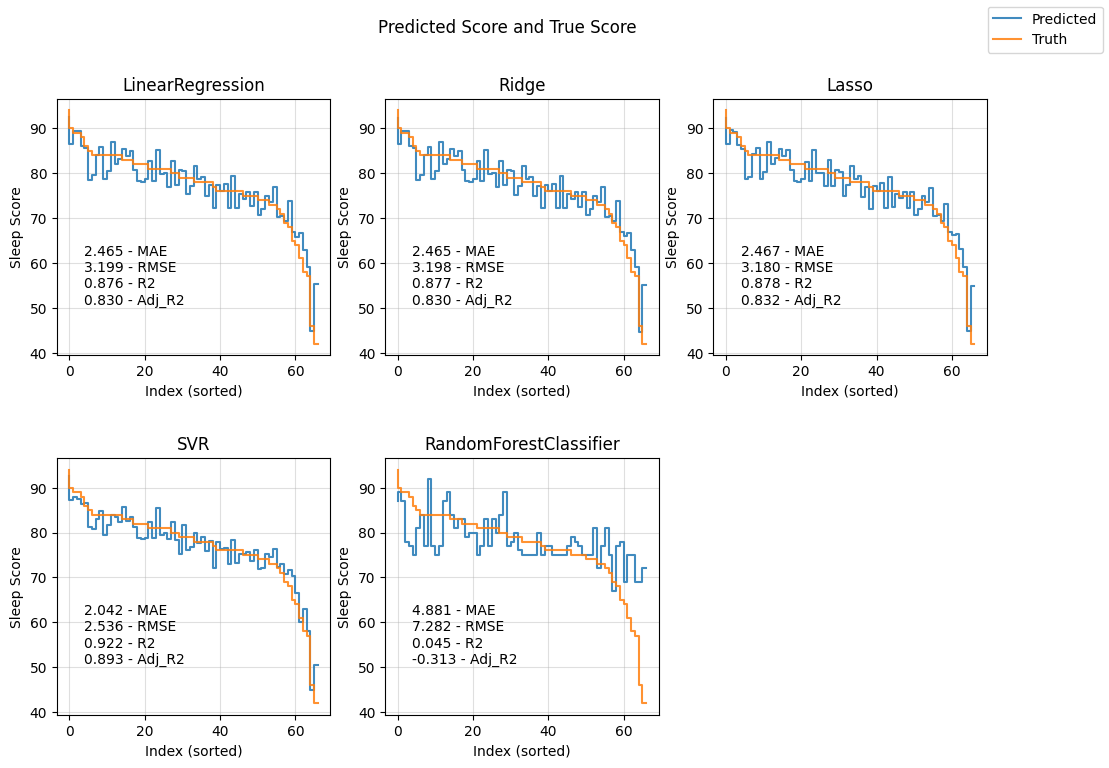

In [374]:
plot_predictions_vs_score_regression(models_regression)

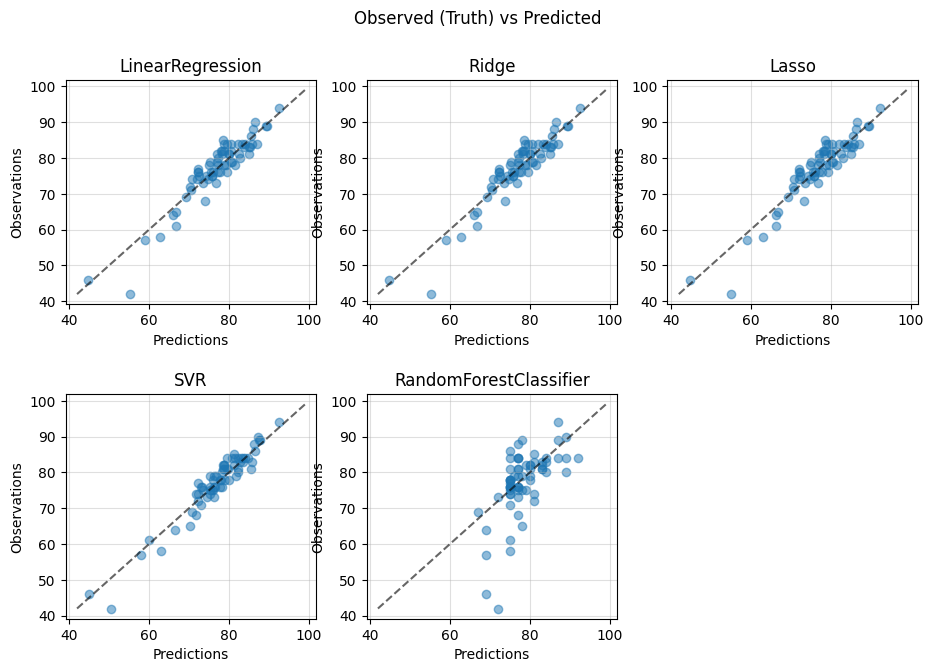

In [371]:
plot_obs_vs_pred_regression(models_regression)

In [398]:
classification_scores = scores_classification(models_classification)

Using binned interval: score_bin_quantile
0 ==========================================================
LogisticRegression
Score: 0.5671641791044776
1 ==========================================================
RidgeClassifier
Score: 0.5074626865671642
2 ==========================================================
SVC
Score: 0.6567164179104478
3 ==========================================================
DecisionTreeClassifier
Score: 0.2835820895522388
4 ==========================================================
AdaBoostClassifier
Score: 0.3582089552238806


In [404]:
pd.DataFrame(classification_scores).T

,Accuracy
LogisticRegression,0.567164
RidgeClassifier,0.507463
SVC,0.656716
DecisionTreeClassifier,0.283582
AdaBoostClassifier,0.358209


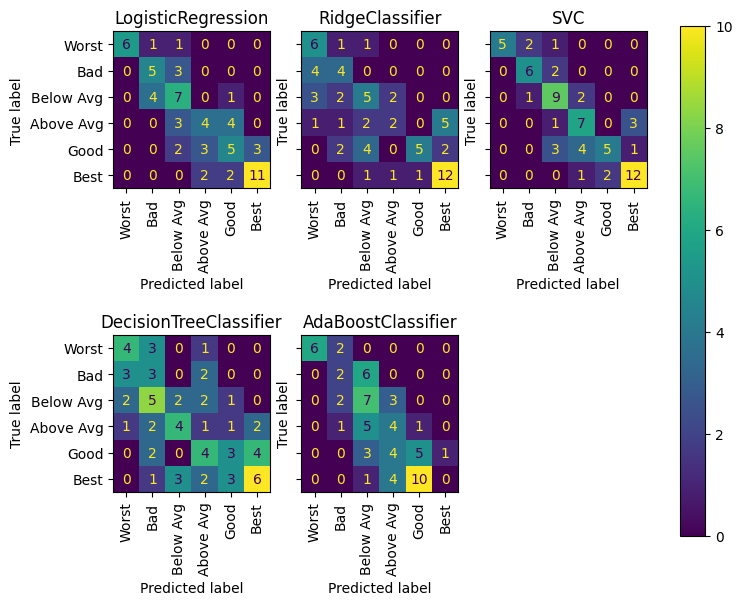

In [235]:
plot_models_confusion_matrix(models_classification)

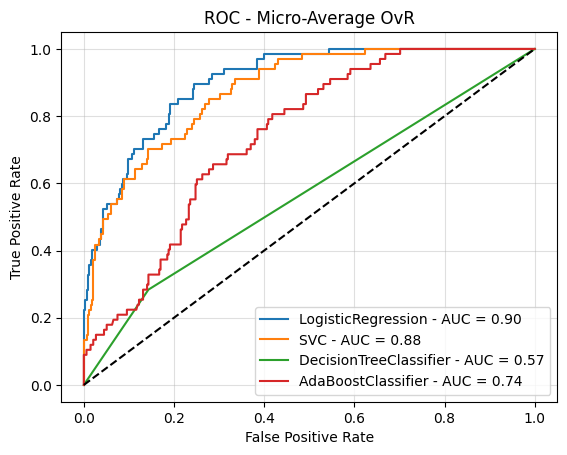

In [236]:
plot_models_roc(models_classification)

### Conclusion

---

